## Averaged flows


In [ ]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from natsort import natsorted
from scipy.ndimage import gaussian_filter
from scipy import spatial
from sklearn.neighbors import KDTree
from scipy.stats import circmean
import os
import sys, time,random
sys.path.append('../vasco_scripts')  # add the relative path to the folder
from defects import *  # import the module from the folder

def progressBar(count_value, total, suffix=''):
    bar_length = 100
    filled_up_Length = int(round(bar_length* count_value / float(total)))
    percentage = round(100.0 * count_value/float(total),1)
    bar = '=' * filled_up_Length + '-' * (bar_length - filled_up_Length)
    sys.stdout.write('[%s] %s%s ...%s\r' %(bar, percentage, '%', suffix))
    sys.stdout.flush()

%matplotlib qt

def divergence_npgrad(flow):
    flow = np.swapaxes(flow, 0, 1)
    Fx, Fy = flow[:, :, 0], flow[:, :, 1]
    dFx_dx = np.gradient(Fx, axis=0)
    dFy_dy = np.gradient(Fy, axis=1)
    return dFx_dx + dFy_dy

def curl_npgrad(flow):
    flow = np.swapaxes(flow, 0, 1)
    Fx, Fy = flow[:, :, 0], flow[:, :, 1]
    dFx_dy = np.gradient(Fx, axis=1)
    dFy_dx = np.gradient(Fy, axis=0)
    curl = dFy_dx - dFx_dy
    return curl

def analyze_defects(img, sigma=25):
    # Calculate mgrid
    yy, xx = np.mgrid[0:img.shape[0], 0:img.shape[1]]
    
    # Calculate orientation analysis
    ori, coh, E = orientation_analysis(img, sigma)
    
    # Compute topological charges
    k = compute_topological_charges(-ori, int_area='cell', origin='lower')
    
    # Localize defects
    defects = localize_defects(k, x_grid=xx, y_grid=yy)
    
    # Compute defect orientation
    compute_defect_orientations(-ori, defects, method='interpolation', x_grid=xx[0,:], y_grid=yy[:,0], interpolation_radius=5, min_sep=1)
    
    # Filter defects by charge
    plushalf = defects[defects['charge']==.5]
    minushalf = defects[defects['charge']==-.5]
    
    return ori, plushalf, minushalf


image_list = glob.glob(r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\*.tif")
image_list = natsorted(image_list, key=lambda y: y.lower())

In [ ]:
image_list[0],image_list[-1],

# Defect dynamics time lapse

## Make dataframe with all defects and save as csv

In [ ]:
%matplotlib qt
PLOT = False
SAVE = False
SAVE_df = not PLOT
minushalf_df = pd.DataFrame([])
plushalf_df = pd.DataFrame([])

if PLOT:
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())


for i,im1 in enumerate(image_list[160:200]):
    img1 = cv2.imread(im1)[:,:,0]
    ori, plushalf, minushalf = analyze_defects(img1, 25)
    frame_num = int(os.path.splitext(os.path.basename(im1))[0].split("Trans__")[-1])
    minushalf['frame'] = frame_num
    plushalf['frame'] = frame_num
    minushalf_df = pd.concat([minushalf_df, minushalf], ignore_index=True)
    plushalf_df = pd.concat([plushalf_df, plushalf], ignore_index=True)

    if PLOT:
        ax.clear() 
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img_clahe = clahe.apply(img1)
        ax.imshow(img_clahe, cmap="gray")

        s = 15
        x = np.arange(0, img1.shape[1], s)
        y = np.arange(0, img1.shape[0], s)

        ax.quiver(x,y, #xx[::s,::s], yy[::s,::s],
            np.cos(ori)[::s,::s], np.sin(ori)[::s,::s], 
            headaxislength=0, headwidth=0, headlength=0, 
            color='lawngreen', scale=60, pivot='mid', alpha=.7)

        alpha_half, scale_half = .9, 40    
        ax.plot(plushalf['x'], plushalf['y'],'ro',markersize=6, alpha=1)
        ax.quiver(plushalf['x'], plushalf['y'], 
            np.cos(plushalf['ang1']), -np.sin(plushalf['ang1']), 
            headaxislength=0, headwidth=0, headlength=0, color='r', scale=scale_half, alpha=alpha_half)

        ax.plot(minushalf['x'], minushalf['y'],'bo',markersize=6, alpha=1)
        for j in range(3):
            ax.quiver(minushalf['x'], minushalf['y'], 
                np.cos(minushalf['ang'+str(j+1)]), -np.sin(minushalf['ang'+str(j+1)]), 
                headaxislength=0, headwidth=0, headlength=0, color='b', scale=scale_half, alpha=alpha_half)
        
        # ----- Save Images with overlay of defects and director field  -----
        if SAVE and PLOT:
            save_path = os.path.join(
                r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)",
                'Nematic1',
                'frame_' + str(i) + ".png"
                )
            # break
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            fig.savefig(save_path, bbox_inches=extent.expanded(1.15, 1.15))

        break

    # ---------------- Save CSV ----------------
    if (not i %50) and SAVE_df:  
        save_path = os.path.join(os.path.dirname(im1), 'Defects', 'MinusHalf1.csv')
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        minushalf_df.to_csv(save_path)
        save_path = os.path.join(os.path.dirname(im1), 'Defects', 'PlusHalf1.csv')
        plushalf_df.to_csv(save_path)

    # save_path = os.path.join(
    #         os.path.dirname(im1), 
    #         'Nematic', 
    #         os.path.splitext(os.path.basename(im1))[0]
    #         )
    # os.makedirs(os.path.dirname(save_path), exist_ok=True)
    # cv2.imwrite(save_path + '_orient.tif', ori)
    # # break

    progressBar(i, len(image_list[160:200]))

if SAVE_df:
    save_path = os.path.join(os.path.dirname(im1), 'Defects', 'MinusHalf1.csv')
    minushalf_df.to_csv(save_path)
    save_path = os.path.join(os.path.dirname(im1), 'Defects', 'PlusHalf1.csv')
    plushalf_df.to_csv(save_path)

In [ ]:
minushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\Defects\MinusHalf1.csv")
plushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\Defects\PlusHalf1.csv")

In [ ]:
import matplotlib

matplotlib.rc('axes', edgecolor='m')
plt.rcParams['xtick.color'] = 'm'
plt.rcParams['ytick.color'] = 'm'

frames = minushalf_df["frame"].unique()

fig, ax = plt.subplots(1,1, figsize=(11,11))
# ax.set_axis_off()
extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# plt.tight_layout()
white_frame = np.ones((2048,2048,3))

for f in frames:
    
    minushalf = minushalf_df[minushalf_df["frame"]==f]
    plushalf = plushalf_df[plushalf_df["frame"]==f]
    
    alpha_half, scale_half = .9, 40   
    ax.clear() 
    ax.imshow(white_frame, "gray")
    ax.plot(plushalf['x'], plushalf['y'],'r.',markersize=6, alpha=1)
    # ax.quiver(plushalf['x'], plushalf['y'], 
    #     np.cos(plushalf['ang1']), -np.sin(plushalf['ang1']), 
    #     headaxislength=0, headwidth=0, headlength=0, color='r', scale=scale_half, alpha=alpha_half)

    ax.plot(minushalf['x'], minushalf['y'],'b.',markersize=6, alpha=1)
    # for i in range(3):
    #     ax.quiver(minushalf['x'], minushalf['y'], 
    #         np.cos(minushalf['ang'+str(i+1)]), -np.sin(minushalf['ang'+str(i+1)]), 
    #         headaxislength=0, headwidth=0, headlength=0, color='b', scale=scale_half, alpha=alpha_half)  

    save_path = os.path.join(
        r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)", 
        'Nematic2',
        'frame_' + str(f) + ".png"
        )
    break
    ax.set_xlim([0, 2048])
    ax.set_ylim([0, 2048])
    # ax.set_box_aspect(1)
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    fig.savefig(save_path, bbox_inches=extent.expanded(1.15, 1.15))             
    # break



## Import CSVs

In [ ]:
first_frame, last_frame

In [ ]:
plushalf_df.frame.max(), minushalf_df.frame.max()
# np.min([minushalf_df["frame"].max(), plushalf_df["frame"].max()]) 

In [ ]:
minushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\Defects\MinusHalf1.csv")
plushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\Defects\PlusHalf1.csv")

minushalf_TM = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\Defects\MinusTM_spots.csv", skiprows=[1,2,3])
plushalf_TM = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\Defects\PlusTM_spots.csv", skiprows=[1,2,3])

first_frame = np.max([minushalf_df["frame"].min(), plushalf_df["frame"].min()]) # Validate this number in image folders
last_frame = np.min([minushalf_df["frame"].max(), plushalf_df["frame"].max()])   # Validate this number in image folders

print("  ////////    PLUS   //////////")
print([(plushalf_TM[plushalf_TM["FRAME"]==i]).shape for i in range(10)])
print([(plushalf_df[plushalf_df["frame"]==i+first_frame]).shape for i in range(10)])

print("\n ////////    MINUS   //////////")
print([(minushalf_TM[minushalf_TM["FRAME"]==i]).shape for i in range(10)])
print([(minushalf_df[minushalf_df["frame"]==i+first_frame]).shape for i in range(10)])

## Find shift and rescale

In [ ]:
plushalf_TM.POSITION_X[plushalf_TM.FRAME==400].shape

In [ ]:
from sklearn import linear_model

%matplotlib inline
frame = 1

fig, axs = plt.subplots(1,2,  figsize=(8,16))

dims = ("x", "y")
lrs = (
    linear_model.LinearRegression(), 
    linear_model.RANSACRegressor(), 
    linear_model.TheilSenRegressor()
    )

slope_intercept = {}

for ax,dd in zip(axs, dims):
    ave_slope, ave_intercept = 0, 0

    X = plushalf_TM["POSITION_"+dd.upper()][plushalf_TM["FRAME"]==frame].iloc[:].sort_values().values
    y = plushalf_df[dd][plushalf_df["frame"]==first_frame+frame].iloc[:]

    if dd=="y":
        # !!! insert image height (e.g. 2048)
        y = (2048 - y) # y- values are flipped
    y = y.sort_values().values

    ax.plot(X, y, "D", alpha=.6)

    for lr in lrs:
        lr.fit(X.reshape(-1, 1), y)
        try:
            slope = lr.estimator_.coef_[0]
            intercept = lr.estimator_.intercept_
        except:
            slope = lr.coef_[0]
            intercept = lr.intercept_

        # use prints to set the SLOPE and INTERCEP globals in the next cell
        print('slope:', slope, '| intercept:', intercept)

        # prdict for line
        line_X = np.arange(X.min()-50, X.max()+50)[:, np.newaxis]
        line_y = lr.predict(line_X)

        ax.plot(line_X, line_y, "--", linewidth=2, alpha=.6,
                label="$%s:$\n $y= %.3f *x %.3f$" %(lr, slope, intercept))   
         
        ave_slope += slope  
        ave_intercept += intercept

    ax.set_title("$< %s >$" %dd.upper())

    ax.set_box_aspect(1)
    ax.legend(loc='upper left')
    print("-------  %s  ------------" %dd.upper())

    slope_intercept[dd] = {"slope": ave_slope/len(lrs),
                             "intercept": ave_intercept/len(lrs)
                             }

    # ave_slope = ave_slope/len(lrs)
    # ave_intercept = ave_intercept/len(lrs)
plt.tight_layout()

### Validate shift and rescale

In [ ]:
%matplotlib inline
SLOPEx = slope_intercept["x"]["slope"]
INTERCEPTx = slope_intercept["x"]["intercept"]
SLOPEy = slope_intercept["y"]["slope"]
INTERCEPTy = slope_intercept["y"]["intercept"]
frame = 1

image_list_all = glob.glob(r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\*.tif")
image_list_all = natsorted(image_list_all, key=lambda y: y.lower())
image_list = image_list_all[first_frame-1:last_frame-1:1]
im1 = image_list[0]

plushalf_TM = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\Defects\PlusTM_spots.csv", skiprows=[1,2,3])
plushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\Defects\PlusHalf1.csv")

# Apply Contrast Limited Adaptive Histogram Equalization
img1 = cv2.imread(im1)[:,:,0]
h_img, w_img = img1.shape
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(255-img_clahe, "gray")

x = plushalf_TM["POSITION_X"][plushalf_TM["FRAME"]==frame].iloc[:].values * SLOPEx + INTERCEPTx
y = h_img - (plushalf_TM["POSITION_Y"][plushalf_TM["FRAME"]==frame].iloc[:].values * SLOPEy + INTERCEPTy)
ax.plot(x, y,'go',markersize=10, alpha=.8)

alpha_half, scale_half = .9, 40  
p_df =  plushalf_df[plushalf_df["frame"]==first_frame+frame]
ax.plot(p_df['x'], p_df['y'],'ro',markersize=6, alpha=.6)
ax.quiver(p_df['x'], p_df['y'], 
    np.cos(p_df['ang1']), -np.sin(p_df['ang1']), 
    headaxislength=0, headwidth=0, headlength=0, color='r', scale=scale_half, alpha=alpha_half)

### Apply angle information data to TrackMate DataFrame

In [ ]:
%matplotlib qt
# SLOPEx = 2.2020369696888773
# INTERCEPTx = -153.5892752236614
# SLOPEy = 2.589611169431241
# INTERCEPTy = -152.43827493084723

def center_pairs(Xlong, Xshort):
    '''find indexes of Xshort in Xlong'''
    from scipy import spatial
    tree = spatial.KDTree(Xlong)
    _, minid = tree.query(Xshort)   
    return minid

minushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\Defects\MinusHalf1.csv")
plushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\Defects\PlusHalf1.csv")

minushalf_TM = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\Defects\MinusTM_spots.csv", skiprows=[1,2,3])
plushalf_TM = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\Defects\PlusTM_spots.csv", skiprows=[1,2,3])

first_frame = minushalf_df["frame"].min() # Validate this number in image folders

plushalf_TM["x_img"] = plushalf_TM["POSITION_X"] * SLOPEx + INTERCEPTx
plushalf_TM["y_img"] = h_img - (plushalf_TM["POSITION_Y"] * SLOPEy + INTERCEPTy)
minushalf_TM["x_img"] = minushalf_TM["POSITION_X"] * SLOPEx + INTERCEPTx
minushalf_TM["y_img"] = h_img - (minushalf_TM["POSITION_Y"] * SLOPEy + INTERCEPTy)

In [ ]:
# find same dots and check
dfs_TM = [plushalf_TM, minushalf_TM]
dfs_ori = [plushalf_df, minushalf_df]

for df_TM, df_ori in zip(dfs_TM, dfs_ori):
    xy_ori = np.array([df_ori["x"], df_ori["y"]]).T
    xy_TM = np.array([df_TM["x_img"].values, df_TM["y_img"].values]).T
    idx = center_pairs(
        xy_ori, #Long Array
        xy_TM #Short Array
        ) 
    # break
    print(xy_ori[idx[100:103]],'\n', xy_TM[100:103],'\n', df_ori[['x', 'y']].loc[idx[100:103]].values)
    print("--------------")

    # replace and add angles
    df_TM[['x_img1','y_img1','ang1','ang2','ang3','charge']] =  df_ori[['x', 'y','ang1','ang2','ang3','charge']].iloc[idx[:]].values


In [ ]:
# test replaced values
%matplotlib inline
frame = 5
last_frame = first_frame + plushalf_TM.FRAME.max()

image_list_all = glob.glob(r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\*.tif")
image_list_all = natsorted(image_list_all, key=lambda y: y.lower())

image_list = image_list_all[first_frame-1:last_frame-1:1]
im1 = image_list[frame]

# Apply Contrast Limited Adaptive Histogram Equalization
img1 = cv2.imread(im1)[:,:,0]
h_img, w_img = img1.shape
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(255-img_clahe, "gray")

# +1/2
idx = plushalf_TM["FRAME"]==frame
ax.plot(plushalf_TM["x_img1"][idx],
        plushalf_TM["y_img1"][idx],'go',
        markersize=10, alpha=.8, label="TrackMate table")
ax.quiver(plushalf_TM['x_img1'][idx], plushalf_TM['y_img1'][idx], 
    np.cos(plushalf_TM['ang1'][idx]), -np.sin(plushalf_TM['ang1'][idx]), 
    headaxislength=0, headwidth=0, headlength=0, color='g', scale=35, alpha=.8)        

p_df =  plushalf_df[plushalf_df["frame"]==first_frame+frame]
ax.plot(p_df['x'], p_df['y'],'ro',markersize=6, alpha=.6, label="detected from orientation")
ax.quiver(p_df['x'], p_df['y'], 
    np.cos(p_df['ang1']), -np.sin(p_df['ang1']), 
    headaxislength=0, headwidth=0, headlength=0, color='r', scale=40, alpha=.8)

# -1/2
idx = minushalf_TM["FRAME"]==frame
ax.plot(minushalf_TM["x_img1"][idx],
        minushalf_TM["y_img1"][idx],'bo',
        markersize=10, alpha=.8, label="TrackMate table")
for i in range(3):
    ax.quiver(minushalf_TM["x_img1"][idx], minushalf_TM["y_img1"][idx], 
        np.cos(minushalf_TM['ang'+str(i+1)][idx]), -np.sin(minushalf_TM['ang'+str(i+1)][idx]), 
        headaxislength=0, headwidth=0, headlength=0, color='b', scale=35, alpha=.6)    

m_df =  minushalf_df[minushalf_df["frame"]==first_frame+frame]
ax.plot(m_df['x'], m_df['y'],'mo',markersize=6, alpha=.6, label="detected from orientation")
for i in range(3):
    ax.quiver(m_df["x"], m_df["y"], 
        np.cos(m_df['ang'+str(i+1)][idx]), -np.sin(m_df['ang'+str(i+1)][idx]), 
        headaxislength=0, headwidth=0, headlength=0, color='m', scale=45, alpha=.6)    

ax.legend(loc='upper right', fontsize=14)

In [ ]:
# Join TrackMate tabels for +1/2 and -1/2
pd.concat([plushalf_TM, minushalf_TM]).to_csv(r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\Defects\PlusAndMinusTM.csv")

# Start Here Find Pairs

In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from natsort import natsorted
from scipy.ndimage import gaussian_filter
from scipy import spatial
from sklearn.neighbors import KDTree
from scipy.stats import circmean, circstd
import os
import sys
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import sys,time,random

def progressBar(count_value, total, suffix=''):
    bar_length = 100
    filled_up_Length = int(round(bar_length* count_value / float(total)))
    percentage = round(100.0 * count_value/float(total),1)
    bar = '=' * filled_up_Length + '-' * (bar_length - filled_up_Length)
    sys.stdout.write('[%s] %s%s ...%s\r' %(bar, percentage, '%', suffix))
    sys.stdout.flush()

def divergence_npgrad(flow):
    flow = np.swapaxes(flow, 0, 1)
    Fx, Fy = flow[:, :, 0], flow[:, :, 1]
    dFx_dx = np.gradient(Fx, axis=0)
    dFy_dy = np.gradient(Fy, axis=1)
    return dFx_dx + dFy_dy

def curl_npgrad(flow):
    flow = np.swapaxes(flow, 0, 1)
    Fx, Fy = flow[:, :, 0], flow[:, :, 1]
    dFx_dy = np.gradient(Fx, axis=1)
    dFy_dx = np.gradient(Fy, axis=0)
    curl = dFy_dx - dFx_dy
    return curl

def roll_func(what,basis,window,func,*args,**kwargs):
    '''https://stackoverflow.com/questions/14300768/pandas-rolling-computation-with-window-based-on-values-instead-of-counts'''
    from scipy.stats import circmean, circstd
    #note that basis must be sorted in order for this to work properly     
    indexed_what = pd.Series(what.values,index=basis.values)
    def applyToWindow(val):
        # using slice_indexer rather that what.loc [val:val+window] allows
        # window limits that are not specifically in the index
        indexer = indexed_what.index.slice_indexer(val-window,val+window,1)
        chunk = indexed_what.iloc[indexer]
        return func(chunk,*args,**kwargs)
    rolled = basis.apply(applyToWindow)
    return rolled

# def plot_rolling_average(df,ax, what_key, basis_key, show=True, win=15, color="red", avfunc=circmean, stdfunc=circstd, *args,**kwargs):
#     df = df.sort_values(by=basis_key)
#     df[what_key+"_ave"] = roll_func(df[what_key], df[basis_key], win, avfunc, *args,**kwargs)*180/np.pi
#     df[what_key+"_std"] = roll_func(df[what_key], df[basis_key], win, stdfunc)*180/np.pi
#     if show:
#         ax.plot(df.distance, df[what_key+"_ave"], "-", color=color, alpha=.6, linewidth=3)
#         ax.fill_between(df[basis_key], 
#                         df[what_key+"_ave"]-df[what_key+"_std"], 
#                         df[what_key+"_ave"]+df[what_key+"_std"], 
#                         color=color, alpha=.2) 
#     return df[[basis_key, what_key+"_ave", what_key+"_std"]] 

def plot_rolling_average(df,ax, what_key, basis_key, show=True, win=15, color="red", avfunc=circmean, stdfunc=circstd, *args,**kwargs):
    df = df.sort_values(by=basis_key)
    df[what_key+"_ave"] = roll_func(df[what_key], df[basis_key], win, avfunc, *args,**kwargs)*180/np.pi
    df[what_key+"_std"] = roll_func(df[what_key], df[basis_key], win, stdfunc)*180/np.pi
    df[what_key+"_count"] = roll_func(1.*df[what_key].abs(), df[basis_key], win, np.sum)
    if show:
        ax.plot(df.distance, df[what_key+"_ave"], "-", color=color, alpha=.6, linewidth=3)
        ax.fill_between(df[basis_key], 
                        df[what_key+"_ave"]-df[what_key+"_std"]/df[what_key+"_count"]**.5, 
                        df[what_key+"_ave"]+df[what_key+"_std"]/df[what_key+"_count"]**.5, 
                        color=color, alpha=.2) 
    return df[[basis_key, what_key+"_ave", what_key+"_std", what_key+"_count"]]       

def msd_from_df(df,xlabel,ylabel,tlabel,id_label,minimal_track=3):
    def msd(x,y):
        return np.cumsum(np.diff(x))**2 + np.cumsum(np.diff(y))**2

    msds = []
    for id in df[id_label].unique():
        idx = (df[id_label]==id)
        if idx.sum()>minimal_track:
            t = df[tlabel][idx].to_numpy()
            t = t[1:]-t[0]
            x = df[xlabel][idx].to_numpy()
            y = df[ylabel][idx].to_numpy()
            msds.append(pd.DataFrame({"FRAME": t, 'MSD':msd(x,y)}).dropna())            
    return pd.concat(msds)

def ang_msd_from_df(df,xlabel,tlabel,id_label,period=2*np.pi, minimal_track=3):
    def msd(x):
        x = np.unwrap(x, period=period)
        return np.cumsum(np.diff(x))**2

    msds = []
    for id in df[id_label].unique():
        idx = (df[id_label]==id)
        if idx.sum()>minimal_track:
            t = df[tlabel][idx].to_numpy()
            t = t[1:]-t[0]
            x = df[xlabel][idx].to_numpy()
            msds.append(pd.DataFrame({"FRAME": t, 'MSD':msd(x)}).dropna())            
    return pd.concat(msds)

plus_minus_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\Defects\PlusAndMinusTM.csv")
plus_minus_df.tail()

,Unnamed: 0,LABEL,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,...,CONTRAST_CH1,SNR_CH1,x_img,y_img,x_img1,y_img1,ang1,ang2,ang3,charge
13257,6657,ID407193,407193,780.0,81.421524,607.0,779.0,0.0,39.0,39,...,0.973672,1.625018,1304.568404,182.944015,1304.0,183.0,2.764602,0.251327,-1.570796,-0.5
13258,6658,ID407202,407202,784.0,81.421516,230.0,840.0,0.0,39.0,39,...,0.973672,1.625018,398.831252,24.940401,399.0,26.0,2.199115,0.314159,-1.759292,-0.5
13259,6659,ID407203,407203,NaN,78.899010,608.0,846.0,0.0,39.0,39,...,0.902189,1.565633,1306.970889,9.399062,1307.0,10.0,-2.513274,-0.816814,1.507964,-0.5
13260,6660,ID407200,407200,783.0,81.421524,626.0,835.0,0.0,39.0,39,...,0.973672,1.625018,1350.215634,37.891517,1351.0,38.0,0.879646,2.638938,-1.445133,-0.5
13261,6661,ID407201,407201,819.0,81.421516,156.0,838.0,0.0,39.0,39,...,0.973672,1.625018,221.047301,30.120847,222.0,30.0,0.628319,-1.382301,2.576106,-0.5


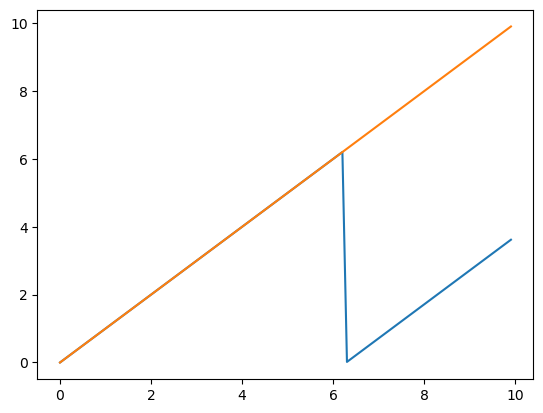

In [2]:
ang = np.arange(0,10,.1)
mod_ang = ang % (2*np.pi)
plt.plot(ang, mod_ang)
plt.plot(ang, np.unwrap(mod_ang, period=(2*np.pi)))

In [3]:
%matplotlib qt
fig, ax1 = plt.subplots(1,1, figsize=(5,5))
plus_minus_df[plus_minus_df.charge==.5].plot.scatter("x_img1","y_img1", ax=ax1,c="r", alpha=.1)
plus_minus_df[plus_minus_df.charge==-.5].plot.scatter("x_img1","y_img1", ax=ax1,c="g", alpha=.1)

<AxesSubplot: xlabel='x_img1', ylabel='y_img1'>

## Number of Defects over time

In [4]:
charge_av = []
charge_std = []
charge_p = []
charge_n = []
for frame in plus_minus_df.FRAME.unique():
    # charge_av.append(plus_minus_df.charge[plus_minus_df.FRAME==frame].sum())
    # charge_std.append(plus_minus_df.charge[plus_minus_df.FRAME==frame].std())
    charge_p.append(plus_minus_df.charge[(plus_minus_df.charge==.5)&(plus_minus_df.FRAME==frame)].sum())
    charge_n.append(plus_minus_df.charge[~(plus_minus_df.charge==.5)&(plus_minus_df.FRAME==frame)].sum())

charge_av = np.array(charge_av)
charge_std = np.array(charge_std)
# plt.plot(plus_minus_df.FRAME.unique(), charge_av, "o")
# plt.fill_between(plus_minus_df.FRAME.unique(), 
#                 charge_av - charge_std, 
#                 charge_av + charge_std, 
#                 color=color, alpha=.2) 
plt.plot(plus_minus_df.FRAME.unique(), charge_p, "o", alpha=.5)
plt.plot(plus_minus_df.FRAME.unique(), np.abs(charge_n), "o", alpha=.5)
plt.gca().set_box_aspect(1)


from sklearn import linear_model
lr = linear_model.TheilSenRegressor()
X = np.array(plus_minus_df.FRAME.unique()).reshape(-1, 1)
y = np.array(charge_p)

lr.fit(X, y)
line_X = np.arange(X.min()-2, X.max()+5)[:, np.newaxis]
line_y = lr.predict(line_X)
plt.plot(line_X, line_y, "--", linewidth=2, alpha=.6)   
plt.title(r"$Absolute ~Charge ~of ~\pm 1/2 ~defects$")
        

Text(0.5, 1.0, '$Absolute ~Charge ~of ~\\pm 1/2 ~defects$')

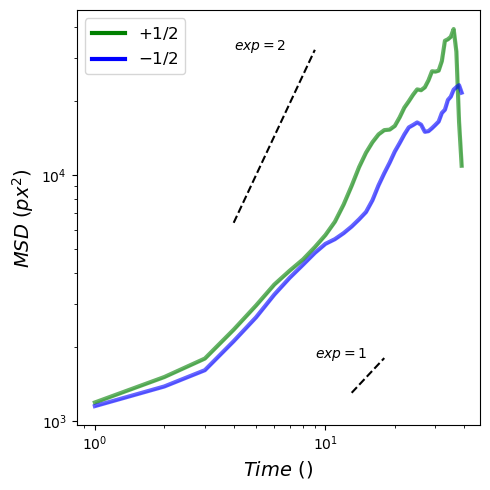

In [5]:
msd_plus_df = msd_from_df(plus_minus_df[plus_minus_df.charge==.5],"x_img1","x_img1","FRAME","TRACK_ID")
msd_minus_df = msd_from_df(plus_minus_df[plus_minus_df.charge==-.5],"x_img1","x_img1","FRAME","TRACK_ID")

%matplotlib inline
fig, ax2 = plt.subplots(1,1, figsize=(5,5))
# msd_plus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="b", alpha=.05)
# msd_minus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="g", alpha=.05)

win = 2

for msd_df,color in zip([msd_plus_df, msd_minus_df], ["g","b"]):

    msd_df = msd_df.sort_values(by="FRAME")
    msd_df["ave"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.mean)
    msd_df["std"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.std)
    msd_df["count"] = roll_func(msd_df.MSD, msd_df.FRAME, win, np.sum)

    ax2.plot(msd_df.FRAME, msd_df["ave"], "-", color=color, alpha=.6, linewidth=3)
    ax2.fill_between(msd_df.FRAME, 
                    msd_df["ave"]-msd_df["std"]/msd_df["count"]**.5, 
                    msd_df["ave"]+msd_df["std"]/msd_df["count"]**.5, 
                    color=color, alpha=.2) 


ax2.plot([0,0],[0,0], "-", color="g", linewidth=3, label=r"$+1/2$")
ax2.plot([0,0],[0,0], "-", color="b", linewidth=3, label=r"$-1/2$")
xref = np.arange(4, 10, 1)
ax2.plot(xref, 4e2*xref**2, "--k", xref+xref[-1], 1e2*(xref+xref[-1])**1,"--k")
ax2.text(xref[0], 4e2*xref[-1]**2, r"$exp=2$", )
ax2.text(xref[-1], 2e2*xref[-1]**1, r"$exp=1$")
ax2.set_xscale('log'); ax2.set_yscale('log')
ax2.set_xlabel(r"$Time ~()$", fontsize=14); ax2.set_ylabel(r"$MSD ~(px^2)$", fontsize=14)
plt.legend(loc='upper left', fontsize=12); plt.tight_layout()

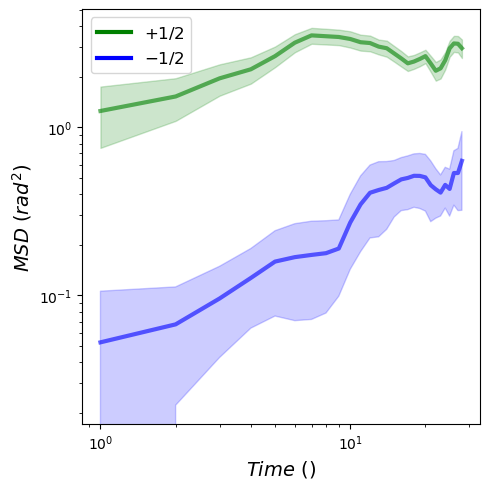

In [6]:
# plus_minus_df["angm_ave"] = circmean(plus_minus_df[["ang1","ang2","ang2"]], high=2/3*np.pi, axis=1)
plus_minus_df["angm_ave"] = plus_minus_df["ang1"] % (2/3*np.pi)
plus_minus_df1 = plus_minus_df[["ang1","angm_ave","charge","FRAME","TRACK_ID"]]

msd_plus_df = ang_msd_from_df(plus_minus_df[(plus_minus_df.charge==.5)&(plus_minus_df.FRAME>10)],
                              "ang1","FRAME","TRACK_ID", minimal_track=20)
msd_minus_df = ang_msd_from_df(plus_minus_df1[(plus_minus_df1.charge==-.5)&(plus_minus_df.FRAME>10)],
                               "angm_ave","FRAME","TRACK_ID",period=2/3*np.pi, minimal_track=20)


# msd_plus_df = msd_from_df(plus_minus_df[plus_minus_df.charge==.5],"ang1","ang1","FRAME","TRACK_ID",minimal_track=10)
# msd_minus_df = msd_from_df(plus_minus_df1[plus_minus_df1.charge==-.5],"angm_ave","angm_ave","FRAME","TRACK_ID")

%matplotlib inline
fig, ax2 = plt.subplots(1,1, figsize=(5,5))
# msd_plus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="b", alpha=.05)
# msd_minus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="g", alpha=.05)

win = 1
 
for msd_df,color in zip([msd_plus_df, msd_minus_df], ["g","b"]):

    msd_df = msd_df.sort_values(by="FRAME")
    msd_df["ave"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.mean)
    msd_df["std"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.std)
    msd_df["count"] = roll_func(msd_df.MSD, msd_df.FRAME, win, np.sum)

    ax2.plot(msd_df.FRAME, msd_df["ave"], "-", color=color, alpha=.6, linewidth=3)
    ax2.fill_between(msd_df.FRAME, 
                    msd_df["ave"]-msd_df["std"]/msd_df["count"]**.5, 
                    msd_df["ave"]+msd_df["std"]/msd_df["count"]**.5, 
                    color=color, alpha=.2) 
    # TODO check the "count" 
    # break


ax2.plot([0,0],[0,0], "-", color="g", linewidth=3, label=r"$+1/2$")
ax2.plot([0,0],[0,0], "-", color="b", linewidth=3, label=r"$-1/2$")
xref = np.arange(60, 100, 1)
# ax2.plot(xref, 1*xref**.5, "--k", xref, 1e-1*xref**1, "--k", xref, 1e-3*xref**2, "--k",)
# ax2.text(xref[0], 1*xref[0]**.5, r"$exp=1/2$", )
# ax2.text(xref[-1], .5*xref[-1]**1, r"$exp=1$")
ax2.set_xscale('log'); ax2.set_yscale('log')
ax2.set_xlabel(r"$Time ~()$", fontsize=14); ax2.set_ylabel(r"$MSD ~(rad^2)$", fontsize=14)
plt.legend(loc='upper left', fontsize=12); plt.tight_layout()

(<AxesSubplot: >, <AxesSubplot: >)

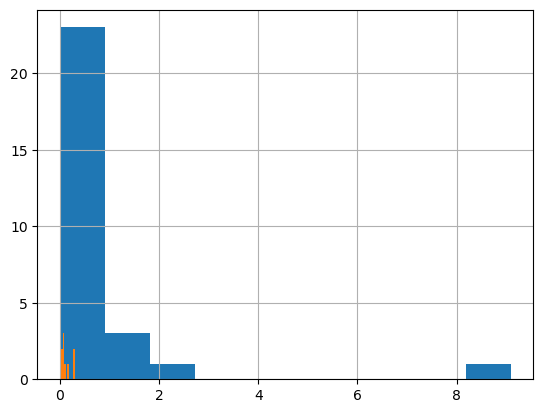

In [7]:
msd_plus_df.MSD[msd_plus_df.FRAME==1].hist(), msd_minus_df.MSD[msd_minus_df.FRAME==1].hist()

In [8]:
def center_pairs(Xlong, Xshort):
    '''find indexes of Xshort in Xlong'''
    tree = spatial.KDTree(Xlong)
    return tree.query(Xshort)

pairs = []

plus_minus_df["FRAME"].unique()[-1]
for frame in plus_minus_df["FRAME"].unique()[:]:
    # print(frame)
    p_idx = np.logical_and(plus_minus_df["FRAME"]==frame, plus_minus_df["charge"]==.5)
    m_idx = np.logical_and(plus_minus_df["FRAME"]==frame, plus_minus_df["charge"]==-.5)
    plus_xy = plus_minus_df[["TRACK_ID","x_img1","y_img1","ang1"]][p_idx]
    minus_xy = plus_minus_df[["TRACK_ID","x_img1","y_img1","ang1","ang2","ang3"]][m_idx]

    dist, idx = center_pairs(minus_xy[["x_img1","y_img1"]], plus_xy[["x_img1","y_img1"]])
    # set a distance that define that defects are a pair (50)
    dist_tresh = dist<60
    # Notice: some TRACK_IDs are nan, meaning that they are not a part from any trajectory
    pairs.append([
        minus_xy["TRACK_ID"].iloc[idx][dist_tresh].values,#.astype(np.int_), 
        plus_xy["TRACK_ID"][dist_tresh].values,#.astype(np.intc)
        dist[dist_tresh]
        ]) 
    # break

pairs_df = pd.DataFrame(np.concatenate(pairs, axis=1).T, columns=["minus", "plus","dist"]).dropna().drop_duplicates()
_, indices = np.unique(pairs_df["minus"], return_index=True)
pairs_df = pairs_df.iloc[indices].copy()

In [9]:
len(pairs_df)

767

In [10]:
radius = 400
neighbour_dist = []
for frame in plus_minus_df["FRAME"].unique()[:]:
    p_idx = np.logical_and(plus_minus_df["FRAME"]==frame, plus_minus_df["charge"]==.5)
    m_idx = np.logical_and(plus_minus_df["FRAME"]==frame, plus_minus_df["charge"]==-.5)
    plus_xy = plus_minus_df[["TRACK_ID","x_img1","y_img1","ang1"]][p_idx]
    minus_xy = plus_minus_df[["TRACK_ID","x_img1","y_img1","ang1","ang2","ang3"]][m_idx]

    tree = KDTree(plus_xy[["x_img1","y_img1"]]) #map all +1/2 defects

    # for each -1/2 map distances to +1/2 neighbours in RADIUS
    for index, row in minus_xy.iterrows():
        # find +1/2 defects within radius (r=maximal_pair_distance)
        ind, dist = tree.query_radius(np.array(row[['x_img1','y_img1']]).reshape(1, -1), 
                                      r=radius, return_distance=True, sort_results=True)
        # find [-1/2, +1/2] pair TRACK_IDs
        try:
            plus_neighbours = plus_xy.iloc[ind[0]].copy()
            plus_neighbours["DIST"] = dist[0]
            plus_pair_id = pairs_df["plus"][pairs_df["minus"]==row["TRACK_ID"]].values[0]
            plus_neighbours["PAIR"] = (plus_neighbours["TRACK_ID"] == plus_pair_id)
            plus_neighbours["mTRACK_ID"] = row["TRACK_ID"]

            plus_neighbours["mp_ang"] = np.arctan2(
                row['y_img1']-plus_neighbours["y_img1"], 
                row['x_img1']-plus_neighbours["x_img1"]
                ) % (2*np.pi)

            plus_neighbours["p_ang_rel"] = (plus_neighbours["ang1"] - plus_neighbours["mp_ang"]) % (2*np.pi)

            plus_neighbours["delta_ang1"] = (row["ang1"] - plus_neighbours["ang1"])
            plus_neighbours["delta_ang2"] = (row["ang2"] - plus_neighbours["ang1"])
            plus_neighbours["delta_ang3"] = (row["ang3"] - plus_neighbours["ang1"])

            plus_neighbours["p_ang"] = plus_neighbours["ang1"]
            plus_neighbours["px_img1"] = plus_neighbours["x_img1"]
            plus_neighbours["py_img1"] = plus_neighbours["y_img1"]
            
            plus_neighbours["mx_img1"] = row["x_img1"]
            plus_neighbours["my_img1"] = row["y_img1"]
            plus_neighbours["m_ang1"] = row["ang1"]
            plus_neighbours["m_ang2"] = row["ang2"]
            plus_neighbours["m_ang3"] = row["ang3"]

            neighbour_dist.append(plus_neighbours[[
                "PAIR","DIST","p_ang_rel", "TRACK_ID", 
                "delta_ang1","delta_ang2","delta_ang3",
                "p_ang", "px_img1", "py_img1",
                "mx_img1", "my_img1",
                "m_ang1", "m_ang2", "m_ang3", "mTRACK_ID"
                ]])
        except:
            pass

    #     break
neighbour_dist = pd.concat(neighbour_dist).dropna()
# grouped = neighbour_dist.groupby('TRACK_ID')["p_ang_rel"]
# neighbour_dist["fuse_up"] = grouped.transform(lambda x: circmean(x)>np.pi).astype('bool')

In [11]:
neighbour_dist["mp_angle"] = np.arctan2(neighbour_dist["my_img1"]-neighbour_dist["py_img1"], 
                                      neighbour_dist["mx_img1"]-neighbour_dist["px_img1"]) % (2*np.pi)


neighbour_dist["angp1_rel"] = (neighbour_dist["p_ang"] - neighbour_dist["mp_angle"]) % (2*np.pi)

grouped = neighbour_dist.groupby('TRACK_ID')["angp1_rel"]
neighbour_dist["fuse_up"] = grouped.transform(lambda x: circmean(x)>np.pi)

In [12]:
neighbour_dist.keys(), neighbour_dist["PAIR"].sum()

(Index(['PAIR', 'DIST', 'p_ang_rel', 'TRACK_ID', 'delta_ang1', 'delta_ang2',
        'delta_ang3', 'p_ang', 'px_img1', 'py_img1', 'mx_img1', 'my_img1',
        'm_ang1', 'm_ang2', 'm_ang3', 'mTRACK_ID', 'mp_angle', 'angp1_rel',
        'fuse_up'],
       dtype='object'),
 3985)

<AxesSubplot: >

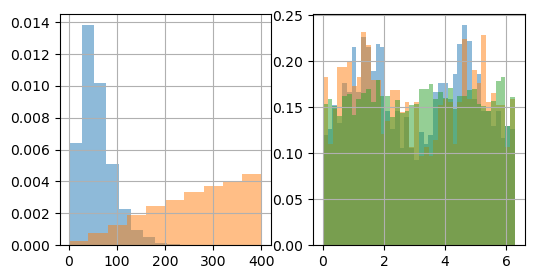

In [13]:
%matplotlib inline
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(6,3))
neighbour_dist.DIST[neighbour_dist["PAIR"]].hist(alpha=.5,density=True,ax=ax1)
neighbour_dist.DIST[~neighbour_dist["PAIR"]].hist(alpha=.5,density=True,ax=ax1)

(neighbour_dist.p_ang_rel[(
        (neighbour_dist["PAIR"]) & (neighbour_dist["fuse_up"]) & (neighbour_dist["DIST"]<120)
        )] % (2*np.pi)).hist(alpha=.5,density=True,bins=40,ax=ax2)

(neighbour_dist.p_ang_rel[(
        (neighbour_dist["PAIR"]) & (~neighbour_dist["fuse_up"]) & (neighbour_dist["DIST"]<120)
        )] % (2*np.pi)).hist(alpha=.5,density=True,bins=40,ax=ax2)   
         
(neighbour_dist.p_ang_rel[(
        (~neighbour_dist["PAIR"]) & (neighbour_dist["DIST"]<120)
        )]% (2*np.pi)).hist(alpha=.5,density=True,bins=40,ax=ax2)

Text(0.5, 1.0, '$Relative ~angle ~btw ~-1/2 ~and ~+1/2$')

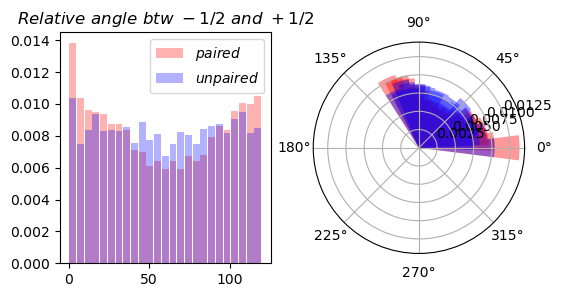

In [14]:
%matplotlib inline
max_dist = 90
paired_up, paired_down, unpaired, delta = [], [], [], []
for i in range(3):
    paired_up.append(neighbour_dist["delta_ang"+str(i+1)]
        [(neighbour_dist["PAIR"])\
        &(neighbour_dist["DIST"]<max_dist)\
        &(neighbour_dist["DIST"]<max_dist)\
        ].values)
    unpaired.append(neighbour_dist["delta_ang"+str(i+1)]
        [(~neighbour_dist["PAIR"])&(neighbour_dist["DIST"]<max_dist)].values)

    # m_ang = neighbour_dist["m_ang"+str(i+1)][
    #         (neighbour_dist["PAIR"])&(neighbour_dist["DIST"]<120)].values
    # p_ang = neighbour_dist["p_ang"][
    #         (neighbour_dist["PAIR"])&(neighbour_dist["DIST"]<120)].values
    # delta.append(m_ang - p_ang)        

paired_up = np.concatenate(paired_up) % (2/3*np.pi)
unpaired = np.concatenate(unpaired) % (2/3*np.pi)
# delta = np.concatenate(delta) % (2/3*np.pi)

fig1 = plt.figure(figsize=(6,3))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')
bins_number = 25  # the [0, 360) interval will be subdivided into this
bins = np.linspace(0, 2/3*np.pi, bins_number+1)

p1,_,_ = ax1.hist(paired_up*180/np.pi, bins*180/np.pi, #one peak 
                    density=True, rwidth=.9, alpha=.3, color="red", label=r"$paired$")
p2,_,_ = ax1.hist(unpaired*180/np.pi, bins*180/np.pi, #one peak 
                    density=True, rwidth=.9, alpha=.3, color="blue", label=r"$unpaired$")
# p3,_,_ = ax1.hist(delta*180/np.pi, bins*180/np.pi, #one peak 
#                     density=True, rwidth=.9, alpha=.3, color="g", label=r"$unpaired$")

width = 2 * np.pi / bins_number
ax2.bar(bins[:bins_number], p1, color="red", width=width, bottom=0.0, alpha=.4)    
ax2.bar(bins[:bins_number], p2, color="blue", width=width, bottom=0.0, alpha=.4,)
# ax2.bar(bins[:bins_number], p3, color="g", width=width, bottom=0.0, alpha=.4,)  
ax1.legend(loc='upper right')    
ax1.set_title(r"$Relative ~angle ~btw ~-1/2 ~and ~+1/2$")                                  

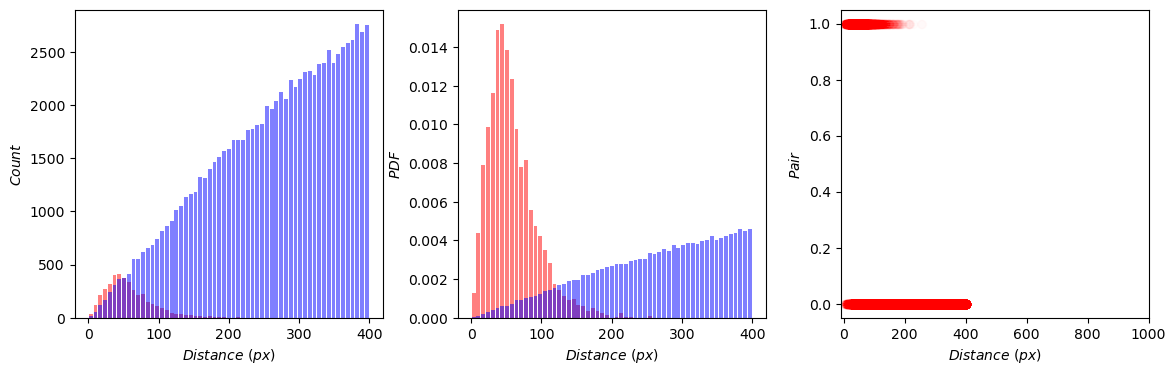

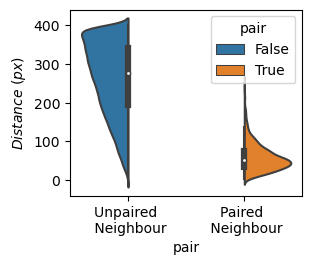

In [15]:
%matplotlib inline
    #     'PAIR', 'DIST', 'p_ang_rel', 'TRACK_ID', 
    #     'delta_ang1', 'delta_ang2', 'delta_ang3', 
    #     'p_ang', 'px_img1', 'py_img1', 
    #     'mx_img1', 'my_img1', 'm_ang1', 'm_ang2', 'm_ang3', 
    #    'mTRACK_ID', 'mp_angle', 'angp1_rel',
    #    'fuse_up'
                
df = neighbour_dist.set_axis(['pair', 'distance', 'p_ang_rel', 'TRACK_ID', 
                                "delta_ang1","delta_ang2","delta_ang3", 
                                'p_ang', 'px_img1', 'py_img1', 
                    'mx_img1', 'my_img1', 'm_ang1', 'm_ang2', 'm_ang3', 
                    'mTRACK_ID', 'mp_angle', 'angp1_rel',
                    'fuse_up'
                            ], axis=1).dropna()

bins_number = 60
bins = np.linspace(0, radius, bins_number)
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(14,4))
# p1 = ax1.hist(distance[pairs_idx], bins, density=False, rwidth=.8, alpha=.5, color="red")
# p2 = ax1.hist(distance[~pairs_idx], bins, density=False, rwidth=.8, alpha=.5, color="blue")
p1 = ax1.hist(df["distance"][df["pair"]], bins, density=False, rwidth=.8, alpha=.5, color="red")
p1 = ax1.hist(df["distance"][~df["pair"]], bins, density=False, rwidth=.8, alpha=.5, color="blue")
ax1.set_xlabel("$Distance ~(px)$")
ax1.set_ylabel("$Count$")
ax1.set_box_aspect(1)

# p1 = ax2.hist(distance[pairs_idx], bins, density=True, rwidth=.8, alpha=.5, color="red")
# p2 = ax2.hist(distance[~pairs_idx], bins, density=True, rwidth=.8, alpha=.5, color="blue")
p1 = ax2.hist(df["distance"][df["pair"]], bins, density=True, rwidth=.8, alpha=.5, color="red")
p1 = ax2.hist(df["distance"][~df["pair"]], bins, density=True, rwidth=.8, alpha=.5, color="blue")
ax2.set_xlabel("$Distance ~(px)$")
ax2.set_ylabel("$PDF$")
ax2.set_box_aspect(1)

ax3.plot(df["distance"],df["pair"], "or", alpha=.01)
ax3.set_xlabel("$Distance ~(px)$")
ax3.set_ylabel("$Pair$")
ax3.set_xlim([-10,1000])
ax3.set_box_aspect(1)

# sns.violinplot([distance[pairs_idx], distance[~pairs_idx]], ax=ax3, split=True)

fig, ax = plt.subplots(figsize=(3,3))
sns.violinplot(data=df, x="pair", y="distance", ax=ax, hue="pair", split=True)
# sns.stripplot(data=df, x="pair", y="distance", ax=ax, marker=".", alpha=.01)
ax.set_xticklabels(["Unpaired \n Neighbour", "Paired \n Neighbour",])
ax.set_ylabel("$Distance ~(px)$")
ax.set_box_aspect(.8)

<BarContainer object of 45 artists>

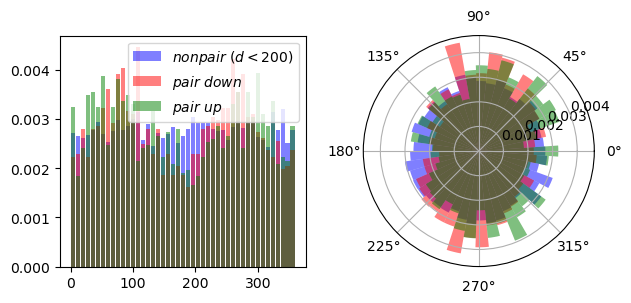

In [16]:
%matplotlib inline
SAVE = False
bins_number = 45  # the [0, 360) interval will be subdivided into this
# number of equal bins
bins = np.linspace(0, 2*np.pi, bins_number+1)
nonpair_ang = df["p_ang_rel"][
    np.logical_and(~df["pair"], df["distance"]<150)
    ] % (2*np.pi)
pair_ang_up = df["p_ang_rel"][(df["pair"])&(df["fuse_up"])] % (2*np.pi)
pair_ang_down = df["p_ang_rel"][(df["pair"])&(~df["fuse_up"])] % (2*np.pi)

fig3 = plt.figure(figsize=(7,3))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')

# ax1.set_title(r"exp:  " + experiment)
nonpair, _, _ =  ax1.hist(nonpair_ang*180/np.pi, bins*180/np.pi, density=True, 
    rwidth=.9, alpha=.5, color="blue", label="$nonpair~(d<200)$")
pair_up, _, _ =  ax1.hist(pair_ang_up*180/np.pi, bins*180/np.pi, density=True, 
    rwidth=.9, alpha=.5, color="red", label="$pair ~down$")
pair_down, _, _ =  ax1.hist(pair_ang_down*180/np.pi, bins*180/np.pi, density=True, 
    rwidth=.9, alpha=.5, color="g", label="$pair ~up$")    

ax1.legend(loc='upper right')

width = 2 * np.pi / bins_number
ax2.bar(bins[:bins_number], nonpair, color="blue",width=width, bottom=0.0, alpha=.5)
ax2.bar(bins[:bins_number], pair_up, color="red",width=width, bottom=0.0, alpha=.5)
ax2.bar(bins[:bins_number], pair_down, color="g",width=width, bottom=0.0, alpha=.5)
# if SAVE:
#     fig3.savefig(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_\Images/pair-nonpair_ang_distribution_hist_" + experiment +".png")


<AxesSubplot: xlabel='mp_angle', ylabel='distance'>

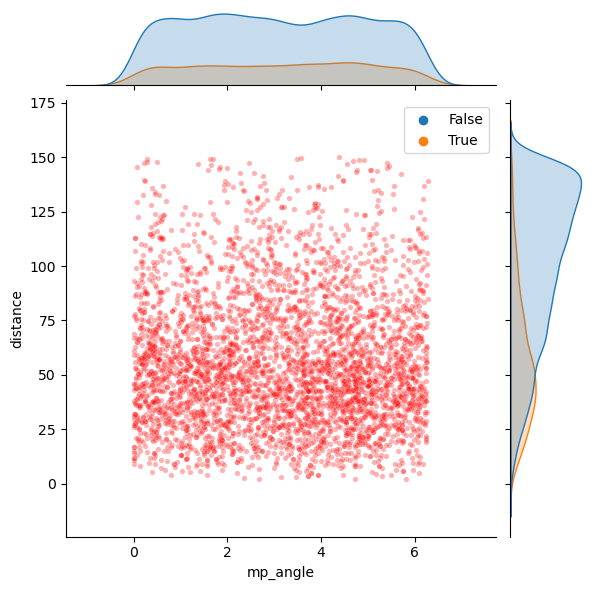

In [17]:
nonpair_ang = df[["mp_angle", "distance","pair"]][
    # np.logical_and(df["pair"]==1, df["distance"]<200)
    df["distance"]<150#df["distance"][df["pair"]==1].max()
    ]
nonpair_ang["mp_angle"] = nonpair_ang["mp_angle"] % (2*np.pi)
g = sns.jointplot(data=nonpair_ang, x="mp_angle", y="distance", 
     hue="pair", alpha=.0, marker=".",)

sns.scatterplot(x=nonpair_ang["mp_angle"][nonpair_ang["pair"]==0], 
    y=nonpair_ang["distance"][nonpair_ang["pair"]==0], 
    s=0, color="blue", ax=g.ax_joint, alpha=.2)   

sns.scatterplot(x=nonpair_ang["mp_angle"][nonpair_ang["pair"]==1], 
    y=nonpair_ang["distance"][nonpair_ang["pair"]==1], 
    s=15, color="red", ax=g.ax_joint, alpha=.3) 

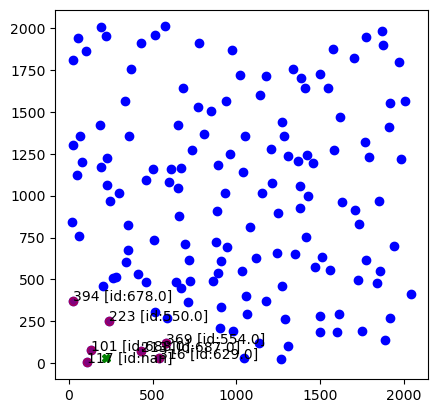

In [18]:
%matplotlib inline
plt.plot(row['x_img1'], row['y_img1'], "Xg")
plt.plot(plus_xy["x_img1"], plus_xy["y_img1"], "ob")
plt.plot(plus_xy["x_img1"].iloc[ind[0]], plus_xy["y_img1"].iloc[ind[0]], "or", alpha=.5)
for ii,dd in zip(ind[0],dist[0]):
    plt.text(plus_xy["x_img1"].iloc[ii], plus_xy["y_img1"].iloc[ii],
        "%2d [id:%s]" % (dd, plus_xy["TRACK_ID"].iloc[ii])
        )

plt.gca().set_aspect(1)

### for each -1/2 defect find the closest +1/2 neighbour, which is not his pair

%matplotlib qt


def equlalize_trajectories(plus_minus_df, p_idx, m_idx):
    ''' makes sure that positive (p_idx) and negative (m_idx) defect trajectory are equal
    according to "FRAME" number
    if missing frame for one of them it removed with dropna()
    '''
    df1 = plus_minus_df[["FRAME", "x_img1","y_img1", "ang1" ]][p_idx]
    df1.set_index('FRAME', inplace=True)
    df2 =  plus_minus_df[["FRAME", "x_img1","y_img1", "ang1","ang2","ang3" ]][m_idx]
    df2.set_index('FRAME', inplace=True)
    df_ = pd.concat([df1, df2], axis=1).dropna()
    return df_.set_axis(["xp","yp", "angp1", "xm","ym", "angm1","angm2","angm3" ], axis=1)

def pair_trajectories(mlabel, plabel, minimal_track=15):
    m_idx = np.logical_and(
        plus_minus_df["TRACK_ID"]==mlabel, 
        plus_minus_df["charge"]==-.5,
        )
    p_idx = np.logical_and(
        plus_minus_df["TRACK_ID"]==plabel, 
        plus_minus_df["charge"]==.5
        )
    if m_idx.sum()>minimal_track and p_idx.sum()>minimal_track:
        return equlalize_trajectories(plus_minus_df, p_idx, m_idx)
    
def get_non_pair_pdef():
    df = pd.DataFrame(columns=["FRAME","TRACK_ID","x_img1","y_img1","ang1"])
    maximal_pair_distance = 1.5*center_pairs(dff_[["xm","ym"]], dff_[["xp","yp"]])[0].max()
    for num,frame in enumerate(dff_.index):
        p_idx = np.logical_and.reduce((
            plus_minus_df["FRAME"]==frame, 
            plus_minus_df["charge"]==.5,
            plus_minus_df["TRACK_ID"] != n,
        ))
        plus_xy = plus_minus_df[["TRACK_ID","FRAME","x_img1","y_img1","ang1"]][p_idx]

        tree = KDTree(plus_xy[["x_img1","y_img1"]])
        # find +1/2 defects within radius (r=maximal_pair_distance)
        ind = tree.query_radius(np.array(dff_[["xm","ym"]].loc[frame]).reshape(1, -1), r=maximal_pair_distance)[0]
        
        if len(ind):
            df = pd.concat([df, plus_xy[["FRAME","TRACK_ID","x_img1","y_img1","ang1"]].iloc[ind]])

    df.set_index('FRAME', inplace=True)
    return df

non_pair_rel_angle = []
fig, ax = plt.subplots(1,1, figsize=(10,10))  
count = 0
for m, n in zip(pairs_df["minus"][:], pairs_df["plus"][:40]):
    dff_ = pair_trajectories(m,n)    
    
    if dff_ is not None:
        maximal_pair_distance = center_pairs(dff_[["xm","ym"]], dff_[["xp","yp"]])[0].max()
        # plt.figure()        
        # count +=1
        # print(count)
        # if count>20:
        #     break
        
        # find next nearest neighbour, which is not a pair
        colors = plt.cm.jet(np.linspace(0, 1, num=len(dff_)))
        non_pair_df = get_non_pair_pdef()
        mp_angle = np.arctan2(np.median(dff_["ym"]) - np.median(non_pair_df["y_img1"]), 
                            np.median(dff_["xm"]) - np.median(non_pair_df["x_img1"])) 
        if mp_angle<0:
            mp_angle = mp_angle + 2*np.pi

        non_pair_df["rel_ang"] = non_pair_df["ang1"] - mp_angle
        non_pair_df["rel_ang"][non_pair_df["rel_ang"]<0] = non_pair_df["rel_ang"][non_pair_df["rel_ang"]<0] + 2*np.pi

        if len(non_pair_df):
            non_pair_rel_angle.append(
                circmean(non_pair_df["rel_ang"])
                )
            # print(non_pair_df.head())
            # break        

        for num,frame in enumerate(dff_.index):
            p_idx = np.logical_and.reduce((
                plus_minus_df["FRAME"]==frame, 
                plus_minus_df["charge"]==.5,
                # plus_minus_df["TRACK_ID"] != n,
            ))
            plus_xy = plus_minus_df[["TRACK_ID","FRAME","x_img1","y_img1","ang1"]][p_idx]

            tree = KDTree(plus_xy[["x_img1","y_img1"]])
            # find +1/2 defects within radius (r=maximal_pair_distance)
            ind = tree.query_radius(np.array(dff_[["xm","ym"]].loc[frame]).reshape(1, -1), r=maximal_pair_distance)[0]

            # plt.figure()
            # non-pair neighbour
            plt.plot(plus_xy["x_img1"].iloc[ind], plus_xy["y_img1"].iloc[ind], "or", alpha=.6)
            plt.quiver(plus_xy["x_img1"].iloc[ind], plus_xy["y_img1"].iloc[ind],
                np.cos(plus_xy["ang1"].iloc[ind]), -np.sin(plus_xy["ang1"].iloc[ind]), 
                headaxislength=0, headwidth=0, headlength=0, color='r', scale=25, alpha=.6)

            # plt.plot(plus_xy["x_img1"], plus_xy["y_img1"], ".b", alpha=.05)
            # plt.quiver(plus_xy["x_img1"], plus_xy["y_img1"],
            #     np.cos(plus_xy["ang1"]), -np.sin(plus_xy["ang1"]), 
            #     headaxislength=0, headwidth=0, headlength=0, color='b', scale=30, alpha=.05)

            circle1 = plt.Circle((dff_["xm"].loc[frame], dff_["ym"].loc[frame]), maximal_pair_distance, color='r', alpha=.05, fill=False)
            plt.gca().add_patch(circle1)
            # # plt.plot(dff_["xm"].loc[frame], dff_["ym"].loc[frame], marker="$M$", color=colors[num])
            # # plt.plot(dff_["xp"].loc[frame], dff_["yp"].loc[frame], marker="$P$", color=colors[num])

            # pair neighbours
            plt.plot(dff_["xm"].loc[frame], dff_["ym"].loc[frame], "o", color=colors[num], markersize=6, alpha=.6)
            for i in range(3):
                plt.quiver(dff_["xm"].loc[frame], dff_["ym"].loc[frame],
                    np.cos(dff_['angm'+str(i+1)].loc[frame]), -np.sin(dff_['angm'+str(i+1)].loc[frame]), 
                    headaxislength=0, headwidth=0, headlength=0, color='m', scale=35, alpha=.2) 

            plt.plot(dff_["xp"].loc[frame], dff_["yp"].loc[frame], "o", color=colors[num], markersize=6, alpha=.6)
            plt.quiver(dff_["xp"].loc[frame], dff_["yp"].loc[frame],
            np.cos(dff_["angp1"].loc[frame]), -np.sin(dff_["angp1"].loc[frame]), 
                headaxislength=0, headwidth=0, headlength=0, color='b', scale=45, alpha=.2)

plt.gca().set_box_aspect(1)

plt.figure()
plt.hist(np.array(non_pair_rel_angle)*180/np.pi,10, density=False, rwidth=.9, alpha=.5, color="red")

## Pair Trajectories

In [19]:
%matplotlib qt

def equlalize_trajectories(plus_minus_df, p_idx, m_idx):
    ''' makes sure that positive (p_idx) and negative (m_idx) defect trajectory are equal
    according to "FRAME" number
    if missing frame for one of them it removed with dropna()
    '''
    df1 = plus_minus_df[["TRACK_ID","FRAME","x_img1","y_img1","ang1"]][p_idx]
    df1.set_index('FRAME', inplace=True)
    df2 =  plus_minus_df[["TRACK_ID","FRAME", "x_img1","y_img1", "ang1","ang2","ang3" ]][m_idx]
    df2.set_index('FRAME', inplace=True)
    df_ = pd.concat([df1, df2], axis=1).dropna()
    return df_.set_axis(["plus_id","xp","yp","angp1", "min_id","xm","ym", "angm1","angm2","angm3"], axis=1)

minimal_track = 5
PLOT = False

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_box_aspect(1)
plt.set_cmap('plasma')
count = 0
mp_distance = []
mp_distance_fusion = []
mp_distance_creation = []
pair_stat = []
all_pairs_df = []
fusion_TF = 1
for (num,m), n in zip(enumerate(pairs_df["minus"]), pairs_df["plus"]):
    m_idx = np.logical_and(plus_minus_df["TRACK_ID"]==m, plus_minus_df["charge"]==-.5)
    p_idx = np.logical_and(plus_minus_df["TRACK_ID"]==n, plus_minus_df["charge"]==.5)
    # minimal track length (20 frames)
    if m_idx.sum()>minimal_track and p_idx.sum()>minimal_track:

        count +=1
        dff_ = equlalize_trajectories(plus_minus_df, p_idx, m_idx)
        all_pairs_df.append(dff_)
        # "xp","yp", "angp1", "xm","ym", "angm1","angm2","angm3" 
        xm, ym = dff_["xm"].values, dff_["ym"].values
        xp, yp = dff_["xp"].values, dff_["yp"].values
        thm = np.array((
            dff_["angm1"].values, 
            dff_["angm2"].values,
            dff_["angm3"].values
        ))
        thp = dff_["angp1"].values
        # thp[thp<0] = thp[thp<0] + 2*np.pi 

        pair_distance = ((xm-xp)**2 + (ym-yp)**2)**.5
        mp_distance.append(pair_distance)
        
        # if distance decrease = fusion
        fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
        if fusion:
            fusion_TF = 1
            mp_distance_fusion.append(pair_distance)
        else:
            fusion_TF = -1
            mp_distance_creation.append(pair_distance)
        
        # angle btw defect centers
        mp_angle = np.arctan2(ym-yp, xm-xp) 
        mp_angle[mp_angle<0] = mp_angle[mp_angle<0] + 2*np.pi
        
        # displacment angle of =1/2 defect
        p_vel_angle = np.arctan2(np.diff(yp), np.diff(xp)) 
        p_vel_angle[p_vel_angle<0] = p_vel_angle[p_vel_angle<0] + 2*np.pi

        diff_thm = (thm - thp).T
        diff_thm[diff_thm<0] = diff_thm[diff_thm<0] + 2*np.pi
        
        thm_min = np.min(np.abs(diff_thm), axis=1) + thp
        thm_min[thm_min<0] = thm_min[thm_min<0] + 2*np.pi
        pair_stat.append([thp-circmean(mp_angle), #np.median(mp_angle)
                          thm-circmean(mp_angle), 
                          p_vel_angle-circmean(mp_angle), 
                          (thp[:1]-p_vel_angle)%(2*np.pi),
                          fusion_TF * pair_distance # negative distance is creation
                        ])

        if PLOT:
            for i in range(3):
                ax.quiver(xm, ym, np.cos(thm[i]), np.sin(thm[i]),color="b", alpha=.3, scale=40)

            ax.quiver(xp, yp, np.cos(thp), np.sin(thp),color="r", alpha=.2)
            ax.quiver(xm, ym, np.cos(thm_min), np.sin(thm_min),color="m", alpha=.3, scale=40)

            ax.quiver(xp[-1], yp[-1], np.cos(thp[-1]), np.sin(thp[-1]),color="r", alpha=.6, scale=15)
            ax.quiver(xm[-1], ym[-1], np.cos(thm_min[-1]), np.sin(thm_min[-1]),color="b", alpha=.6, scale=15)

            ax.scatter(xm, ym, c=np.arange(len(xm)), s=40, alpha=.8)
            ax.scatter(xp, yp, c=np.arange(len(xp)), s=40, alpha=.8)
            # ax.text(xp[-1]-10, yp[-1]+10, str((thp[-1]*180/np.pi)//1), fontsize=20)
            ax.text(xp[-1], yp[-1], "%s" %str(((thp[-1]-circmean(mp_angle))*180/np.pi)//1 % 360) , fontsize=20)
            ax.text(xm[-1], ym[-1], "%s" %str(((thm.min()-circmean(mp_angle))*180/np.pi)//1 % 360) , fontsize=20)
    
    progressBar(num, len(pairs_df))

all_pairs_df = pd.concat(all_pairs_df)

# all_pairs_df.to_csv(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects\all_Pairs.csv")

C:\Users\victo\AppData\Local\Temp\ipykernel_24188\329362603.py:52: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\victo\AppData\Local\Temp\ipykernel_24188\329362603.py:52: RuntimeWarning: Mean of empty slice.
  fusion = pair_distance[:len(pair_distance)//2].mean() > pair_distance[len(pair_distance)//2:].mean()
c:\Users\victo\miniconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [20]:
# pair_stat.append([thp-circmean(mp_angle), #np.median(mp_angle)
#                     thm-circmean(mp_angle), 
#                     p_vel_angle-circmean(mp_angle), 
#                     (thp[:1]-p_vel_angle)%(2*np.pi),
#                     pair_distance
#                 ])
df = pd.DataFrame(data={
    "p_ang": np.concatenate([p[0] for p in pair_stat]), 
    "m_ang1": np.concatenate([p[1][0] for p in pair_stat]),
    "m_ang2": np.concatenate([p[1][1] for p in pair_stat]), 
    "m_ang3": np.concatenate([p[1][2] for p in pair_stat]), 
    # "p_vel_angle": np.concatenate([p[2] for p in pair_stat]), 
    # "X": np.concatenate(pair_stat)[:,3], 
    "distance": np.concatenate([pair[4] for pair in pair_stat]), 
    }).dropna()


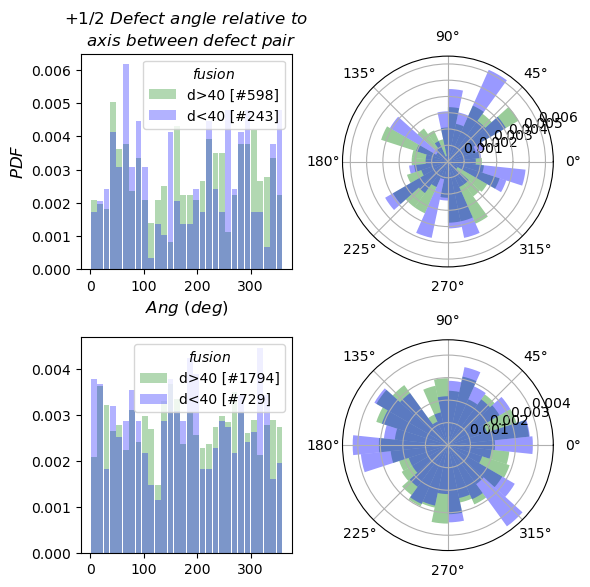

In [21]:
%matplotlib inline
dist = 40
bins_number = 30  # the [0, 360) interval will be subdivided into this
# number of equal bins
bins = np.linspace(0, 2*np.pi, bins_number+1)
width = 2 * np.pi / bins_number

fig3 = plt.figure(figsize=(6,6))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222, projection='polar')
ax3 = plt.subplot(223)
ax4 = plt.subplot(224, projection='polar')
ax1.set_ylabel("$PDF$", fontsize=12)
ax1.set_xlabel("$Ang~(deg)$", fontsize=12)

df_f = df[df["distance"]>0].copy()
df_cr = df[df["distance"]<0].copy()

# df1 = df_f[np.logical_and(
#                     df_f["distance"]>40, 
#                     df_f["distance"]<60,
#                    )].copy()

df1 = df_f.copy()
df1["distance"] = df1["distance"].abs()

m_ang_close, m_ang_far, m_ang_all = [], [], []
for i in range(3):
    m_ang_close.append(df1["m_ang"+str(i+1)][df1["distance"]<dist].values)
    m_ang_far.append(df1["m_ang"+str(i+1)][df1["distance"]>dist].values)
    m_ang_all.append(df1["m_ang"+str(i+1)].values)
    # break
m_ang_close = np.concatenate(m_ang_close)
m_ang_far = np.concatenate(m_ang_far)
m_ang_all = np.concatenate(m_ang_all)  

# p0,_,_ = ax3.hist((m_ang_all % (2*np.pi))*180/np.pi, bins*180/np.pi, 
#                     density=True, rwidth=.9, alpha=.3, color="red",
#                     label="all [#%s]" %(len(m_ang_all))
#                     )
# ax4.bar(bins[:bins_number], p0, width=width, bottom=0.0, alpha=.4, color="red")

p0,_,_ = ax3.hist((m_ang_far % (2*np.pi))*180/np.pi, bins*180/np.pi, 
                    density=True, rwidth=.9, alpha=.3, color="green",
                    label="d>%s [#%s]" %(dist, len(m_ang_far))
                    )
ax4.bar(bins[:bins_number], p0, width=width, bottom=0.0, alpha=.4, color="green")
p0,_,_ = ax3.hist((m_ang_close % (2*np.pi))*180/np.pi, bins*180/np.pi, 
                    density=True, rwidth=.9, alpha=.3, color="blue",
                    label="d<%s [#%s]" %(dist, len(m_ang_close))
                    )
ax4.bar(bins[:bins_number], p0, width=width, bottom=0.0, alpha=.4, color="blue")

# p0,_,_ = ax1.hist((df1["p_ang"] % (2*np.pi))*180/np.pi, bins*180/np.pi, 
#                   density=True, rwidth=.9, alpha=.3, color="red",
#                   label="all [#%s]" %(len(df1["p_ang"]))
#                   )
# ax2.bar(bins[:bins_number], p0, color="red", width=width, bottom=0.0, alpha=.5)

p1,_,_ = ax1.hist((df1["p_ang"][df1["distance"]>dist] % (2*np.pi))*180/np.pi, bins*180/np.pi, 
                  density=True, rwidth=.9, alpha=.3, color="green",
                  label="d>%s [#%s]" %(dist, len(df1["p_ang"][df1["distance"]>dist]))
                  )
ax2.bar(bins[:bins_number], p1, color="green", width=width, bottom=0.0, alpha=.4)

p2,_,_ = ax1.hist((df1["p_ang"][df1["distance"]<dist] % (2*np.pi))*180/np.pi, bins*180/np.pi,
                   density=True, rwidth=.9, alpha=.3, color="blue",
                   label="d<%s [#%s]" %(dist, len(df1["p_ang"][df1["distance"]<dist]))
                   )
ax2.bar(bins[:bins_number], p2, color="blue", width=width, bottom=0.0, alpha=.4)

ax1.legend(loc='upper right')
ax1.get_legend().set_title("$fusion$")
ax1.set_title("$+1/2 ~Defect ~angle ~relative ~to$\n $ ~axis ~between ~defect ~pair$")

ax3.legend(loc='upper right')
ax3.get_legend().set_title("$fusion$")
plt.tight_layout()

In [22]:
np.median(df_f["distance"]), -np.median(df_cr["distance"])

(56.08029957123981, 59.93329625508679)

Median vals. 56.08029957123981 59.93329625508679


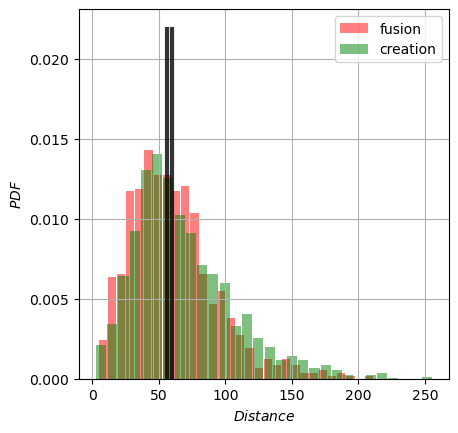

In [23]:
%matplotlib inline
ax = df_f["distance"].hist(bins=30, density=True, rwidth=.9, label="fusion", color="red", alpha=.5)
ax.vlines(np.median(df_f["distance"]), 0, .022, "k", linewidth=3, alpha=.8)
(-1* df_cr["distance"]).hist(bins=30, density=True, rwidth=.9, label="creation", color="green",alpha=.5)
ax.vlines(-np.median(df_cr["distance"]), 0, .022, "k", linewidth=3, alpha=.8)
ax.set_box_aspect(1)
ax.set_ylabel("$PDF$"); ax.set_xlabel("$Distance$")
ax.legend(loc='upper right')
print("Median vals.", np.median(df_f["distance"]), -np.median(df_cr["distance"]))

In [24]:
''' -- ADD ---
1) distance btw pairs 
2)angle btw + and - centers 
3) fusion/creation 
'''
all_pairs_df["distance"] = (
    (all_pairs_df["xm"]-all_pairs_df["xp"])**2 + (all_pairs_df["ym"]-all_pairs_df["yp"])**2
    )**.5

all_pairs_df["mp_angle"] = np.arctan2(all_pairs_df["ym"]-all_pairs_df["yp"], 
                                      all_pairs_df["xm"]-all_pairs_df["xp"]) % (2*np.pi)

grouped = all_pairs_df.groupby('min_id')["distance"]
all_pairs_df["fusion"] = grouped.transform(lambda x: x[:len(x)//2].mean()>x[len(x)//2:].mean())

C:\Users\victo\AppData\Local\Temp\ipykernel_24188\3381741901.py:14: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  all_pairs_df["fusion"] = grouped.transform(lambda x: x[:len(x)//2].mean()>x[len(x)//2:].mean())


In [25]:
fuse_df = all_pairs_df[all_pairs_df["fusion"]]
fuse_df["angp1_rel"] = (fuse_df["angp1"] - fuse_df["mp_angle"]) % (2*np.pi)
for i in range(3):
    fuse_df["angm"+str(i+1)+"_rel"] = (fuse_df["angm"+str(i+1)] - fuse_df["mp_angle"]) % (2*np.pi)

grouped = fuse_df.groupby('plus_id')["angp1_rel"]
fuse_df["fuse_up"] = grouped.transform(lambda x: circmean(x)>np.pi)

create_df = all_pairs_df.loc[~all_pairs_df["fusion"]]
create_df["angp1_rel"] = (create_df["angp1"] - create_df["mp_angle"]) % (2*np.pi)

Text(0.5, 1.0, 'dist>40')

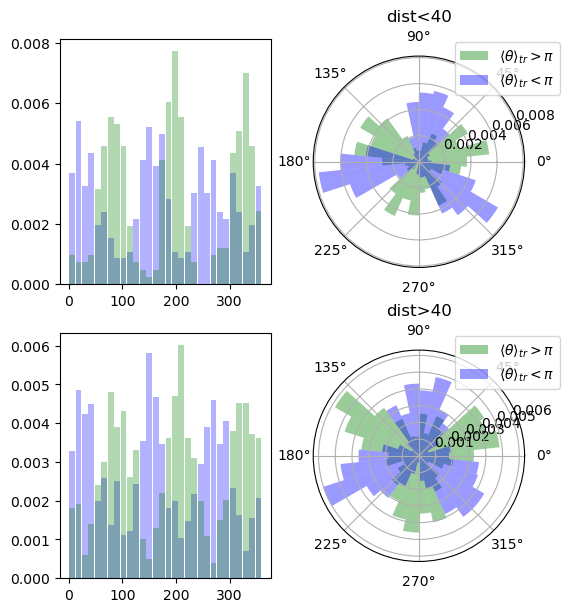

In [26]:
%matplotlib inline
dist = 40
m_ang_up_close, m_ang_down_close = [], []
m_ang_up_far, m_ang_down_far = [], []
for i in range(3):
    m_ang_up_close.append(fuse_df["angm"+str(i+1)+"_rel"][np.logical_and(
        fuse_df["fuse_up"], fuse_df["distance"]<dist)].values)
    m_ang_down_close.append(fuse_df["angm"+str(i+1)+"_rel"][np.logical_and(
        ~fuse_df["fuse_up"], fuse_df["distance"]<dist)].values)
    m_ang_up_far.append(fuse_df["angm"+str(i+1)+"_rel"][np.logical_and(
        fuse_df["fuse_up"], fuse_df["distance"]>dist)].values)
    m_ang_down_far.append(fuse_df["angm"+str(i+1)+"_rel"][np.logical_and(
        ~fuse_df["fuse_up"], fuse_df["distance"]>dist)].values)
    # break
    
m_ang_up_close = np.concatenate(m_ang_up_close) 
m_ang_down_close = np.concatenate(m_ang_down_close) 
m_ang_up_far = np.concatenate(m_ang_up_far) 
m_ang_down_far = np.concatenate(m_ang_down_far) 

fig1 = plt.figure(figsize=(6,7))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222, projection='polar')
ax3 = plt.subplot(223)
ax4 = plt.subplot(224, projection='polar')

# p1,_,_ = ax1.hist((m_ang_up_close % (2/3*np.pi))*180/np.pi, bins*180/np.pi, #one peak
p1,_,_ = ax1.hist((m_ang_up_close % (2*np.pi))*180/np.pi, bins*180/np.pi, #three peaks
                    density=True, rwidth=.9, alpha=.3, color="b")

# p2,_,_ = ax1.hist(360-(-m_ang_down_close % (2/3*np.pi))*180/np.pi, bins*180/np.pi, #one peak
p2,_,_ = ax1.hist((m_ang_down_close % (2*np.pi))*180/np.pi, bins*180/np.pi, #three peaks
                    density=True, rwidth=.9, alpha=.3, color="g")

ax2.bar(bins[:bins_number], p1, color="green", width=width, bottom=0.0, alpha=.4,
                    label=r"$\langle \theta \rangle _{tr} > \pi$")
ax2.bar(bins[:bins_number], p2, color="blue", width=width, bottom=0.0, alpha=.4,
                    label=r"$\langle \theta \rangle _{tr} < \pi$")
ax2.legend(bbox_to_anchor=(1.2, 1.1)); ax2.set_title("dist<%s" % dist)

# p3,_,_ = ax3.hist((m_ang_up_far % (2/3*np.pi))*180/np.pi, bins*180/np.pi, #one peak
p3,_,_ = ax3.hist((m_ang_up_far % (2*np.pi))*180/np.pi, bins*180/np.pi, #three peaks
                    density=True, rwidth=.9, alpha=.3, color="b")

# p4,_,_ = ax3.hist(360-(-m_ang_down_far % (2/3*np.pi))*180/np.pi, bins*180/np.pi, #one peak
p4,_,_ = ax3.hist(m_ang_down_far % (2*np.pi)*180/np.pi, bins*180/np.pi, #three peaks
                    density=True, rwidth=.9, alpha=.3, color="g")

ax4.bar(bins[:bins_number], p3, color="green", width=width, bottom=0.0, alpha=.4,
                    label=r"$\langle \theta \rangle _{tr} > \pi$")
ax4.bar(bins[:bins_number], p4, color="blue", width=width, bottom=0.0, alpha=.4,
                    label=r"$\langle \theta \rangle _{tr} < \pi$")
ax4.legend(bbox_to_anchor=(1.2, 1.1)); ax4.set_title("dist>%s" % dist)


Text(0, 0.5, '$Angle$')

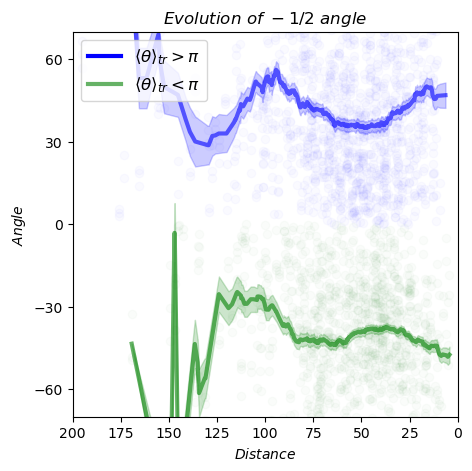

In [27]:
%matplotlib inline                 

df_all = fuse_df
win = 15

fig, ax1 = plt.subplots(1,1,  figsize=(5,5))

for i in range(3):
    y_up = df_all["angm"+str(i+1)+"_rel"][fuse_df["fuse_up"]] % (2/3*np.pi)
    y_down = df_all["angm"+str(i+1)+"_rel"][~fuse_df["fuse_up"]] % (2/3*np.pi)
    ax1.plot(df_all.distance[fuse_df["fuse_up"]], y_up*180/np.pi, "ob", alpha=.02)
    ax1.plot(df_all.distance[~fuse_df["fuse_up"]], -120+(y_down*180/np.pi), "og", alpha=.02)

m_ang_all = []
for i in range(3):
    m_ang_all.append(fuse_df["angm"+str(i+1)+"_rel"].values)
    # break
    
df_all["angm_rel_all"] = circmean(np.array(m_ang_all) % (2/3*np.pi), axis=0) % (2/3*np.pi)

df = df_all[fuse_df["fuse_up"]]
df_av_up = plot_rolling_average(df, ax1, "angm_rel_all", "distance", win=win, color="b", high=2/3*np.pi)
ax1.plot([0,0],[0,0], "-b", linewidth=3, label=r"$\langle \theta \rangle _{tr} > \pi$")
      

df = df_all[~fuse_df["fuse_up"]]
df_av_down = plot_rolling_average(df, ax1, "angm_rel_all", "distance", show=False, win=win, color="g", high=2/3*np.pi)
# flip to negative values to show divergence
ax1.plot(df_av_down["distance"], -120+df_av_down["angm_rel_all_ave"], "-", color="g", alpha=.6, linewidth=3,
         label=r"$\langle \theta \rangle _{tr} < \pi$")
ax1.fill_between(df_av_down.distance, 
                 (-120+df_av_down["angm_rel_all_ave"])-df_av_down["angm_rel_all_std"]/df_av_down["angm_rel_all_count"]**.5, 
                 (-120+df_av_down["angm_rel_all_ave"])+df_av_down["angm_rel_all_std"]/df_av_down["angm_rel_all_count"]**.5, 
                 color="g", alpha=.2)

plt.xlim([0,200]); plt.ylim([-70,70]); plt.yticks(np.arange(-60, 61, 30))
plt.gca().set_box_aspect(1); plt.gca().invert_xaxis()
plt.legend(fontsize=12); plt.title("$Evolution ~of ~-1/2 ~angle$")
plt.xlabel("$Distance$"); plt.ylabel("$Angle$")    

## Relative angle between defects in a pair

Text(0.5, 1.0, '$Relative ~angle ~btw ~-1/2 ~and ~+1/2 ~defects$')

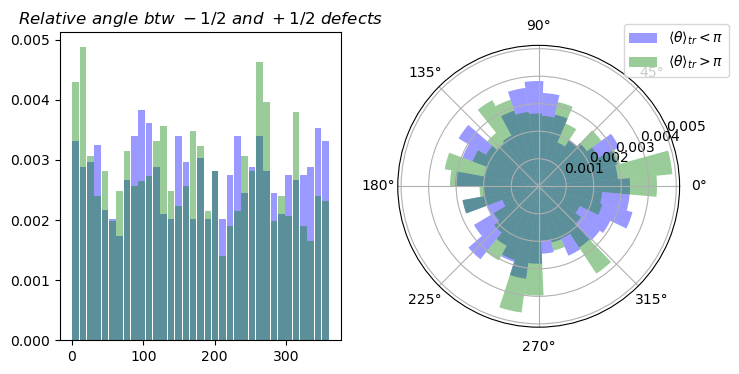

In [28]:
fig1 = plt.figure(figsize=(8,4))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')
bins_number = 35  # the [0, 360) interval will be subdivided into this
bins = np.linspace(0, 2*np.pi, bins_number+1) #* 180/np.pi
width = 2 * np.pi / bins_number

m_ang_all = []
for i in range(3):
    fuse_df["mp_angle"+str(i+1)]  = (fuse_df["angm"+str(i+1)] - fuse_df.angp1) % (2*np.pi)

mp_ang = []
mp_ang_up = []
mp_ang_down = []
for i in range(3):
    mp_ang.append(fuse_df["mp_angle"+str(i+1)].values)
    mp_ang_up.append(fuse_df["mp_angle"+str(i+1)][fuse_df.fuse_up].values)
    mp_ang_down.append(fuse_df["mp_angle"+str(i+1)][~fuse_df.fuse_up].values)   

mp_ang_up = np.array(mp_ang_up)
mp_ang_down = np.array(mp_ang_down)
fuse_df["mp_angle_av"]= circmean(mp_ang, axis=0, low=0., high=2/3*np.pi)

p1,_,_ = ax1.hist(mp_ang_up.ravel() *180/np.pi, bins*180/np.pi, # 3 paeks
# p1,_,_ = ax1.hist(fuse_df["mp_angle_av"][fuse_df.fuse_up] *180/np.pi, bins*180/np.pi, # one peak
    alpha=.4, rwidth=.9, density=True, color="b")# ,  df.shape  
ax2.bar(bins[:bins_number], p1, color="b", width=width, bottom=0.0, alpha=.4,
    label=r"$\langle \theta \rangle _{tr} < \pi$")

p2,_,_ = ax1.hist(mp_ang_down.ravel() *180/np.pi, bins*180/np.pi, # 3 paeks
# p2,_,_ = ax1.hist(fuse_df["mp_angle_av"][~fuse_df.fuse_up] *180/np.pi, bins*180/np.pi, # one peak
    alpha=.4, rwidth=.9, density=True, color="g")# ,  df.shape  
ax2.bar(bins[:bins_number], p2, color="g", width=width, bottom=0.0, alpha=.4,
    label=r"$\langle \theta \rangle _{tr} > \pi$")

ax2.legend(bbox_to_anchor=(1.2, 1.1)); ax1.set_title(r"$Relative ~angle ~btw ~-1/2 ~and ~+1/2 ~defects$")

Text(0, 0.5, '$Angle ~(deg)$')

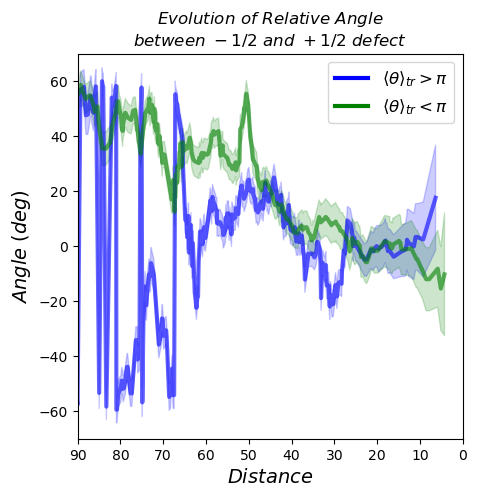

In [29]:
fig, ax1 = plt.subplots(1,1,  figsize=(5,5))

win = 5
# for i in range(3):
    # df_av_up = plot_rolling_average(fuse_df[fuse_df.fuse_up], ax1, "mp_angle"+str(i+1), "distance", win=win, color="b", low=-2/3*np.pi, high=0)
    # df_av_up = plot_rolling_average(fuse_df[~fuse_df.fuse_up], ax1, "mp_angle"+str(i+1), "distance", win=win, color="g", low=0*np.pi, high=2/3*np.pi)


# ax1.plot(df_all.distance[fuse_df.fuse_up], (df_all.mp_angle_av[fuse_df.fuse_up] % (2/3*np.pi) - (1/3*np.pi))*180/np.pi, "ob", alpha=.05)
# ax1.plot(df_all.distance[~fuse_df.fuse_up], (df_all.mp_angle_av[~fuse_df.fuse_up] % (2/3*np.pi) - (1/3*np.pi))*180/np.pi, "og", alpha=.05)

df_av_up = plot_rolling_average(fuse_df[fuse_df.fuse_up], ax1, "mp_angle_av", "distance", win=win, color="b", low=-1/3*np.pi, high=1/3*np.pi)
df_av_up = plot_rolling_average(fuse_df[~fuse_df.fuse_up], ax1, "mp_angle_av", "distance", win=win, color="g", low=-1/3*np.pi, high=1/3*np.pi)

ax1.plot([0,0],[0,0], "-b", linewidth=3, label=r"$\langle \theta \rangle _{tr} > \pi$")
ax1.plot([0,0],[0,0], "-g", linewidth=3, label=r"$\langle \theta \rangle _{tr} < \pi$")


plt.xlim([90,0]); plt.ylim([-70, 70]); #plt.yticks(np.arange(0, 121, 30))
plt.gca().set_box_aspect(1); #plt.gca().invert_xaxis()  
plt.legend(fontsize=12); 
plt.title(r"$Evolution ~of ~Relative ~Angle$" +"\n" + r"$between ~-1/2 ~and ~+1/2 ~defect$")
plt.xlabel(r"$Distance$", fontsize=14); plt.ylabel(r"$Angle ~(deg)$", fontsize=14)    

#### How +1/2 defects orient ralatively to axis of their movement

In [32]:
''' -- ADD ---
1) distance btw pairs 
2)angle btw + and - centers 
3) fusion/creation 
'''
all_pairs_df["distance"] = (
    (all_pairs_df["xm"]-all_pairs_df["xp"])**2 + (all_pairs_df["ym"]-all_pairs_df["yp"])**2
    )**.5

all_pairs_df["mp_angle"] = np.arctan2(all_pairs_df["ym"]-all_pairs_df["yp"], 
                                      all_pairs_df["xm"]-all_pairs_df["xp"]) % (2*np.pi)


all_pairs_df["angp1_rel"] = (all_pairs_df["angp1"] - all_pairs_df["mp_angle"]) % (2*np.pi)
for i in range(3):
    all_pairs_df["angm"+str(i+1)+"_rel"] = (all_pairs_df["angm"+str(i+1)] - all_pairs_df["mp_angle"]) % (2*np.pi)

grouped = all_pairs_df.groupby('plus_id')["angp1_rel"]
all_pairs_df["fuse_up"] = grouped.transform(lambda x: circmean(x)>np.pi)

all_pairs_df["p_vel_angle"] = np.arctan2(all_pairs_df.groupby('plus_id')["yp"].diff(periods=3).fillna(0), 
                                        all_pairs_df.groupby('plus_id')["xp"].diff(periods=3).fillna(0))

all_pairs_df["p_vel_angle_rel"] = all_pairs_df["p_vel_angle"] - all_pairs_df["mp_angle"]                                 
all_pairs_df["p_vel_angle_rel"][all_pairs_df["p_vel_angle"]==0] = 0
# TODO p_angle relative to trajectory path
all_pairs_df["angp1_rel_vel_angle"] = (all_pairs_df["angp1"]- all_pairs_df["p_vel_angle"]) %(2*np.pi)

Text(0.5, 1.0, 'Angle of +1/2 defect movement \n its trajectory axis')

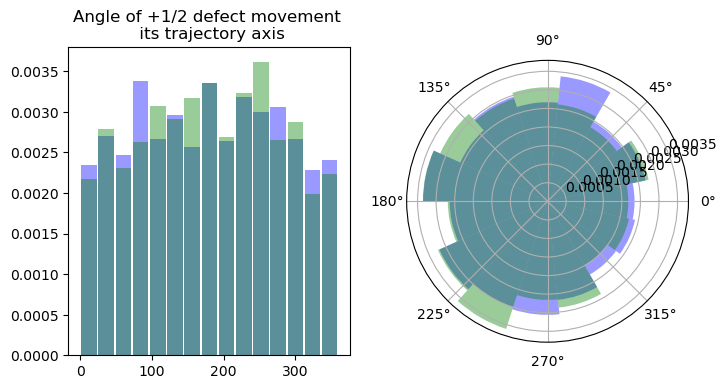

In [34]:
%matplotlib inline
bins_number = 15  # the [0, 360) interval will be subdivided into this
bins = np.linspace(0, 2*np.pi, bins_number+1) #* 180/np.pi
width = 2 * np.pi / bins_number

df = all_pairs_df.reset_index()
up = df["angp1_rel_vel_angle"][(df["fuse_up"])&(df.distance<200)]
down = df["angp1_rel_vel_angle"][~(df["fuse_up"])&(df.distance<200)]

plt.figure(figsize=(8,4))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')
# p0,_,_ = ax1.hist(all*180/np.pi, bins*180/np.pi, alpha=.4, density=True, rwidth=.9, color="r")
p1,_,_ = ax1.hist(up*180/np.pi, bins*180/np.pi, alpha=.4, density=True, rwidth=.9, color="b")
p2,_,_ = ax1.hist(down*180/np.pi, bins*180/np.pi, alpha=.4, density=True, rwidth=.9, color="g")

# ax2.bar(bins[:bins_number], p0, color="r", width=width, bottom=0., alpha=.4)
ax2.bar(bins[:bins_number], p1, color="b", width=width, bottom=0., alpha=.4,
    label=r"%.1f $(\langle \theta \rangle _{tr} > \pi)$" % (circmean(up, high=np.pi)*180/np.pi))
    # label="up: %.1f" % (circmean(up, high=np.pi)*180/np.pi))
ax2.bar(bins[:bins_number], p2, color="g", width=width, bottom=0., alpha=.4,
    label=r"%.1f $(\langle \theta \rangle _{tr} < \pi)$"  % (circmean(down, high=np.pi)*180/np.pi))
# ax2.legend(fontsize=12)
ax1.set_title("Angle of +1/2 defect movement \n its trajectory axis")

#### How +1/2 defects move ralatively to axis between defect pair

 up: 159.8 [std: 73.1] 
 down: 173.4 [std: 65.1] 
 all: 168.8 [std: 68.9]


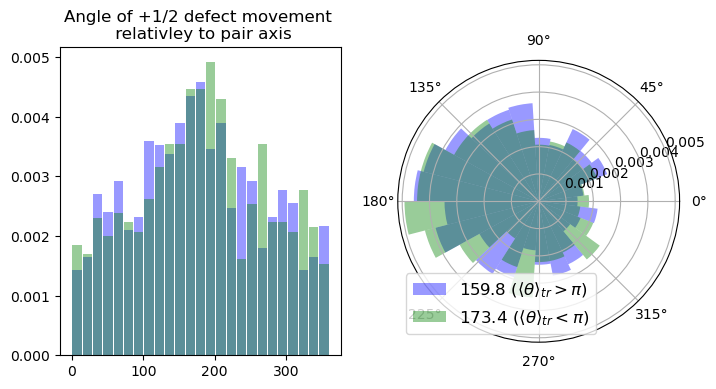

In [35]:
%matplotlib inline
bins_number = 25  # the [0, 360) interval will be subdivided into this
bins = np.linspace(0, 2*np.pi, bins_number+1) #* 180/np.pi
width = 2 * np.pi / bins_number

all = all_pairs_df["p_vel_angle_rel"][~(all_pairs_df["p_vel_angle"]==0)] % (2*np.pi)
up = all_pairs_df["p_vel_angle_rel"][(all_pairs_df["fuse_up"]) & ~(all_pairs_df["p_vel_angle"]==0)] % (2*np.pi)
down = all_pairs_df["p_vel_angle_rel"][~(all_pairs_df["fuse_up"]) & ~(all_pairs_df["p_vel_angle"]==0)] % (2*np.pi)
# ------- early/late
# up = all_pairs_df["p_vel_angle_rel"][~(all_pairs_df["p_vel_angle"]==0) & (all_pairs_df.index<30)] % (2*np.pi)
# down = all_pairs_df["p_vel_angle_rel"][~(all_pairs_df["p_vel_angle"]==0) & (all_pairs_df.index>60)] % (2*np.pi)


plt.figure(figsize=(8,4))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')
# p0,_,_ = ax1.hist(all*180/np.pi, bins*180/np.pi, alpha=.4, density=True, rwidth=.9, color="r")
p1,_,_ = ax1.hist(up*180/np.pi, bins*180/np.pi, alpha=.4, density=True, rwidth=.9, color="b")
p2,_,_ = ax1.hist(down*180/np.pi, bins*180/np.pi, alpha=.4, density=True, rwidth=.9, color="g")

# ax2.bar(bins[:bins_number], p0, color="r", width=width, bottom=0., alpha=.4)
ax2.bar(bins[:bins_number], p1, color="b", width=width, bottom=0., alpha=.4,
    label=r"%.1f $(\langle \theta \rangle _{tr} > \pi)$" % (circmean(up, high=np.pi)*180/np.pi))
    # label="up: %.1f" % (circmean(up, high=np.pi)*180/np.pi))
ax2.bar(bins[:bins_number], p2, color="g", width=width, bottom=0., alpha=.4,
    label=r"%.1f $(\langle \theta \rangle _{tr} < \pi)$"  % (circmean(down, high=np.pi)*180/np.pi))
ax2.legend(fontsize=12)
ax1.set_title("Angle of +1/2 defect movement \n relativley to pair axis")

print(
    " up: %.1f [std: %.1f] \n down: %.1f [std: %.1f] \n all: %.1f [std: %.1f]"
    % (circmean(up, high=np.pi)*180/np.pi, circstd(up, high=np.pi)*180/np.pi,
    circmean(down, high=np.pi)*180/np.pi, circstd(down, high=np.pi)*180/np.pi,
    circmean(all, high=np.pi)*180/np.pi, circstd(all, high=np.pi)*180/np.pi)
    )

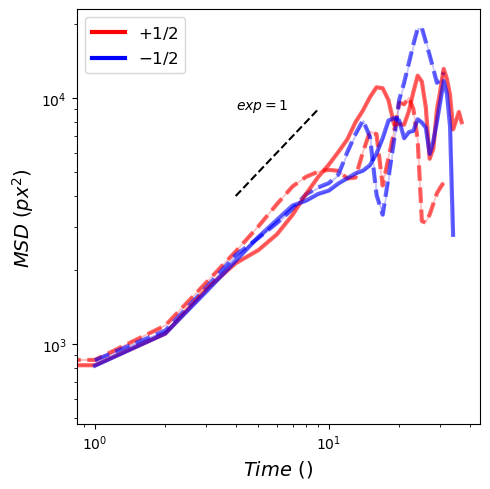

In [36]:
min_dist, max_dist = 40, 40
min_track = 1

# msd_plus_df_far = msd_from_df(all_pairs_df[~all_pairs_df.fusion].reset_index(),"xp","yp","FRAME","plus_id",minimal_track=min_track)
# msd_minus_df_far = msd_from_df(all_pairs_df[~all_pairs_df.fusion].reset_index(),"xm","ym","FRAME","min_id",minimal_track=min_track)

# df = all_pairs_df[all_pairs_df.fusion]
# msd_plus_df_far = msd_from_df(df[df.distance>min_dist].reset_index(),"xp","yp","FRAME","plus_id",minimal_track=min_track)
# msd_minus_df_far = msd_from_df(df[df.distance>min_dist].reset_index(),"xm","ym","FRAME","min_id",minimal_track=min_track)
# msd_plus_df_close = msd_from_df(df[df.distance<max_dist].reset_index(),"xp","yp","FRAME","plus_id",minimal_track=min_track)
# msd_minus_df_close= msd_from_df(df[df.distance<max_dist].reset_index(),"xm","ym","FRAME","min_id",minimal_track=min_track)
# dfs = [msd_plus_df_far, msd_minus_df_far, msd_plus_df_close, msd_minus_df_close]

df = all_pairs_df[all_pairs_df.fusion]
plus_fuse = msd_from_df(df.reset_index(),"xp","yp","FRAME","plus_id",minimal_track=min_track)
minus_fuse = msd_from_df(df.reset_index(),"xm","ym","FRAME","min_id",minimal_track=min_track)

df = all_pairs_df[~all_pairs_df.fusion]
plus_cr = msd_from_df(df.reset_index(),"xp","yp","FRAME","plus_id",minimal_track=min_track)
minus_cr = msd_from_df(df.reset_index(),"xm","ym","FRAME","min_id",minimal_track=min_track)
dfs = [plus_fuse, minus_fuse, plus_cr, minus_cr]


%matplotlib inline
fig, ax1 = plt.subplots(1,1, figsize=(5,5))
# msd_plus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="b", alpha=.05)
# msd_minus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="g", alpha=.05)

win = 1

colors = ["--r","--b", "-r", "-b"]

for msd_df,color in zip(dfs, colors):
    msd_df = msd_df.sort_values(by="FRAME")
    msd_df["ave"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.mean)
    msd_df["std"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.std)
    msd_df["count"] = roll_func(msd_df.MSD, msd_df.FRAME, win, np.sum)

    ax1.plot(msd_df.FRAME, msd_df["ave"], color, alpha=.6, linewidth=3)
    ax1.fill_between(msd_df.FRAME, 
                    msd_df["ave"]-msd_df["std"]/msd_df["count"]**.5, 
                    msd_df["ave"]+msd_df["std"]/msd_df["count"]**.5, 
                    color=''.join(x for x in color if x.isalpha()), alpha=.2) 


ax1.plot([0,0],[0,0], "-", color="r", linewidth=3, label=r"$+1/2$")
ax1.plot([0,0],[0,0], "-", color="b", linewidth=3, label=r"$-1/2$")
xref = np.arange(4, 10, 1)
ax1.plot(xref, 1e3*xref**1,"--k")
ax1.text(xref[0], 1e3*xref[-1]**1, r"$exp=1$")
ax1.set_xscale('log'); ax1.set_yscale('log')
ax1.set_xlabel(r"$Time ~()$", fontsize=14); ax1.set_ylabel(r"$MSD ~(px^2)$", fontsize=14)
plt.legend(loc='upper left', fontsize=12); plt.tight_layout()


(6.073560485184176, 6.044234362449744)

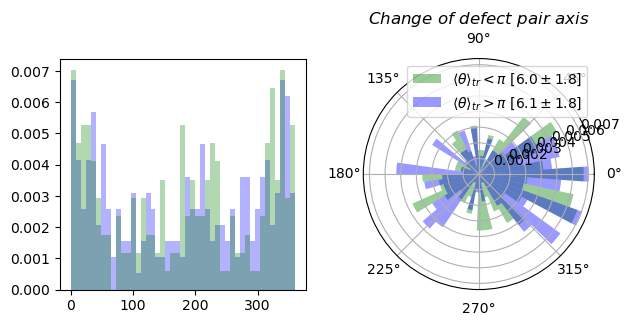

In [37]:
%matplotlib inline
diff_period = 4
dist = 60
bins_number = 45  # the [0, 360) interval will be subdivided into this
# number of equal bins
bins = np.linspace(0, 2*np.pi, bins_number+1)
width = 2 * np.pi / bins_number

# (df_all["mp_angle"][(df_all.fuse_up) & (df_all.distance<40)].diff() % 2*np.pi).hist(alpha=.6)
# (df_all["mp_angle"][~(df_all.fuse_up) & (df_all.distance<40)].diff() % 2*np.pi).hist(alpha=.6)

dtheta_up = df_all["mp_angle"][(df_all.fuse_up) & (df_all.distance<dist)].diff(periods=diff_period).dropna() % (2*np.pi)
dtheta_down = df_all["mp_angle"][(~df_all.fuse_up) & (df_all.distance<dist)].diff(periods=diff_period).dropna() % (2*np.pi)

fig1 = plt.figure(figsize=(7,3))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')

p1,_,_ = ax1.hist(dtheta_up*180/np.pi, bins*180/np.pi, #three peaks
                    density=True, rwidth=1., alpha=.3, color="b")
p2,_,_ = ax1.hist(dtheta_down*180/np.pi, bins*180/np.pi, #three peaks
                    density=True, rwidth=1., alpha=.3, color="g")

ax2.bar(bins[:bins_number], p1, color="green", width=width, bottom=0.0, alpha=.4,
        label=r"$\langle \theta \rangle _{tr} < \pi ~[%.1f  \pm%.1f]$" 
        %(circmean(dtheta_up), circstd(dtheta_up)))
ax2.bar(bins[:bins_number], p2, color="blue", width=width, bottom=0.0, alpha=.4,
        label=r"$\langle \theta \rangle _{tr} > \pi ~[%.1f  \pm%.1f]$" 
        %(circmean(dtheta_down), circstd(dtheta_down)))

ax2.legend(loc='upper right')
ax2.set_title(r"$Change ~of ~defect ~pair ~axis$")

circmean(dtheta_down, low=0, high=2*np.pi), circmean(dtheta_up, low=0, high=2*np.pi)

Text(0, 0.5, '$\\Delta \\theta, ~Angle ~change ~(deg)$')

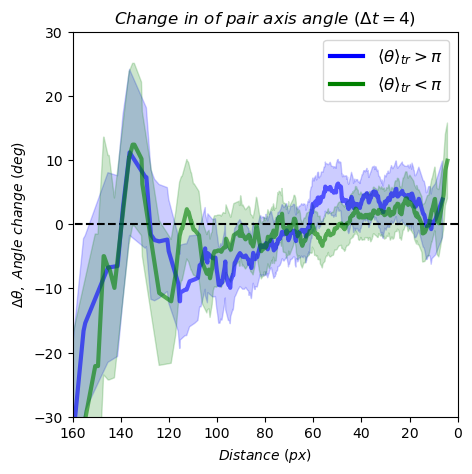

In [38]:
%matplotlib inline
win = 30
df = df_all.copy().set_index("distance")

dtheta_up = df["mp_angle"][df.fuse_up].diff(periods=diff_period).dropna()# % (2*np.pi)
dtheta_up = dtheta_up.reset_index()
dtheta_down = df["mp_angle"][~df.fuse_up].diff(periods=diff_period).dropna()
dtheta_down = dtheta_down.reset_index()

fig, ax1 = plt.subplots(1,1,  figsize=(5,5))
ax1.plot([0,160], [0,0], "--k", alpha=1)
# ax1.plot(dtheta_up.distance, (dtheta_up.mp_angle)*180/np.pi, "ob", alpha=.05)
# ax1.plot(dtheta_down.distance, (dtheta_down.mp_angle)*180/np.pi, "og", alpha=.05)

ax1.plot([0,0],[0,0], "-b", linewidth=3, label=r"$\langle \theta \rangle _{tr} > \pi$")
ax1.plot([0,0],[0,0], "-g", linewidth=3, label=r"$\langle \theta \rangle _{tr} < \pi$")

df_av_up = plot_rolling_average(dtheta_up, ax1, "mp_angle", "distance", win=win, color="b", low=-np.pi, high=np.pi)
df_av_down = plot_rolling_average(dtheta_down, ax1, "mp_angle", "distance", win=win, color="g", low=-np.pi, high=np.pi)

# ax1.invert_xaxis()
ylim = 30
ax1.set_box_aspect(1) 
ax1.set_ylim([-ylim,ylim])
ax1.set_xlim([160,0])
plt.legend(fontsize=12); plt.title(r"$Change ~in ~of ~pair ~axis ~angle ~(\Delta t=%s)$" % diff_period)
plt.xlabel("$Distance ~(px)$"); plt.ylabel(r"$\Delta \theta, ~Angle ~change ~(deg)$")

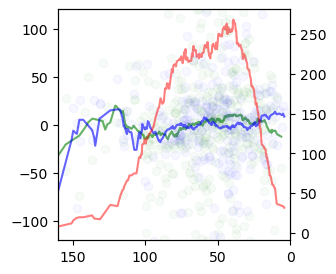

In [39]:
fig, ax1 = plt.subplots(figsize=(3,3))

df = dtheta_up.sort_values(by="distance")
mean = roll_func(df.mp_angle, df.distance,
          15, circmean, low=-np.pi, high=np.pi)*180/np.pi
ax1.plot(df.distance, df.mp_angle*180/np.pi, "og", alpha=.03)
ax1.plot(df.distance, mean, "-g", alpha=.6)

df = dtheta_down.sort_values(by="distance")
mean = roll_func(df.mp_angle, df.distance,
          15, circmean, low=-np.pi, high=np.pi)*180/np.pi
ax1.plot(df.distance, df.mp_angle*180/np.pi, "ob", alpha=.03)
ax1.plot(df.distance, mean, "-b", alpha=.6)
ax1.set_ylim([-120,120]); ax1.set_xlim([160,0])

num_of_samples = roll_func(1*df.mp_angle.abs(), df.distance,
          15, np.sum)
ax2 = ax1.twinx()
ax2.plot(df.distance, num_of_samples, "-r", alpha=.5)

# df_av_down = plot_rolling_average(df, ax1, "angm_rel_all", "distance", show=False, win=win, color="g", high=2/3*np.pi)
# # flip to negative values to show divergence
# ax1.plot(df_av_down["distance"], -120+df_av_down["angm_rel_all_ave"], "-", color="g", alpha=.6, linewidth=3,
#          label=r"$\langle \theta \rangle _{tr} < \pi$")
# ax1.fill_between(df_av_down.distance, 
#                  (-120+df_av_down["angm_rel_all_ave"])-df_av_down["angm_rel_all_std"], 
#                  (-120+df_av_down["angm_rel_all_ave"])+df_av_down["angm_rel_all_std"], 
#                  color="g", alpha=.2)


### Compare defect velocity (creation-fusion)

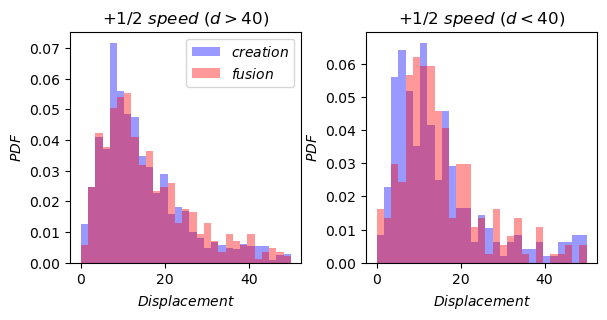

In [40]:
# create_df.shape, create_df.diff().shape
bins = np.linspace(0, 50, 30)

cr_df = create_df.reset_index()
cr_df["p_speed"] = (cr_df["xp"].diff()**2 + cr_df["yp"].diff()**2)**.5 / cr_df["FRAME"].diff()
cr_df = cr_df.dropna()

f_df = fuse_df.reset_index()
f_df["p_speed"] = (f_df["xp"].diff()**2 + f_df["yp"].diff()**2)**.5 / f_df["FRAME"].diff()
f_df = f_df.dropna()

fig, (ax1,ax2) = plt.subplots(1,2,  figsize=(7,3))

ax1.hist(cr_df["p_speed"][cr_df["distance"]>40], density=True, bins=bins, alpha=.4, color="b",
label=r"$creation$")
ax1.hist(f_df["p_speed"][f_df["distance"]>40], density=True, bins=bins, alpha=.4, color="r",
label=r"$fusion$")    

ax2.hist(cr_df["p_speed"][cr_df["distance"]<40], density=True, bins=bins, alpha=.4, color="b")
ax2.hist(f_df["p_speed"][f_df["distance"]<40], density=True, bins=bins, alpha=.4, color="r")

ax1.set_box_aspect(1); ax1.set_title(r"$+1/2 ~speed ~(d>40)$")
ax1.set_xlabel(r"$Displacement$"); ax1.set_ylabel(r"$PDF$")
ax2.set_box_aspect(1); ax2.set_title(r"$+1/2 ~speed  ~(d<40)$")
ax2.set_xlabel(r"$Displacement$"); ax2.set_ylabel(r"$PDF$")
ax1.legend(loc='upper right')

In [41]:
# FUSION
mp_distance_fusion_mat = np.zeros([len(mp_distance_fusion), len(max(mp_distance_fusion, key = lambda x: len(x)))])
mp_distance_fusion_mat[:] = np.nan
for i, dist in enumerate(mp_distance_fusion):
    # plt.plot(np.arange(len(dist)), np.flip(dist), alpha=.2)  
    mp_distance_fusion_mat[i,0:len(dist)] = np.flip(dist)

# CREATION
mp_distance_creation_mat = np.zeros([len(mp_distance_creation), len(max(mp_distance_creation, key = lambda x: len(x)))])
mp_distance_creation_mat[:] = np.nan
for i, dist in enumerate(mp_distance_creation):  
    # plt.plot(np.arange(len(dist)), dist, alpha=.2) 
    # plt.scatter(np.arange(len(dist)), dist, c=np.arange(len(dist)), s=5, alpha=.2, cmap="plasma")     
    mp_distance_creation_mat[i,0:len(dist)] = dist  

mean_fusion, stdiv_fusion = np.flip(np.nanmean(mp_distance_fusion_mat, axis=0)), np.flip(np.nanstd(mp_distance_fusion_mat, axis=0))
mean_creation, stdiv_creation = np.nanmean(mp_distance_creation_mat, axis=0), np.nanstd(mp_distance_creation_mat, axis=0)     

## Fit fusion-creation mean trajectories

FUSION
slope: -1.5921104903240515 | intercept: 56.56035833067833
Y=0 @ X=: 35.525397687170745
CREATION
slope: 0.08667370453819373 | intercept: 83.14721914416353
Y=0 @ X=: -959.3130879449578


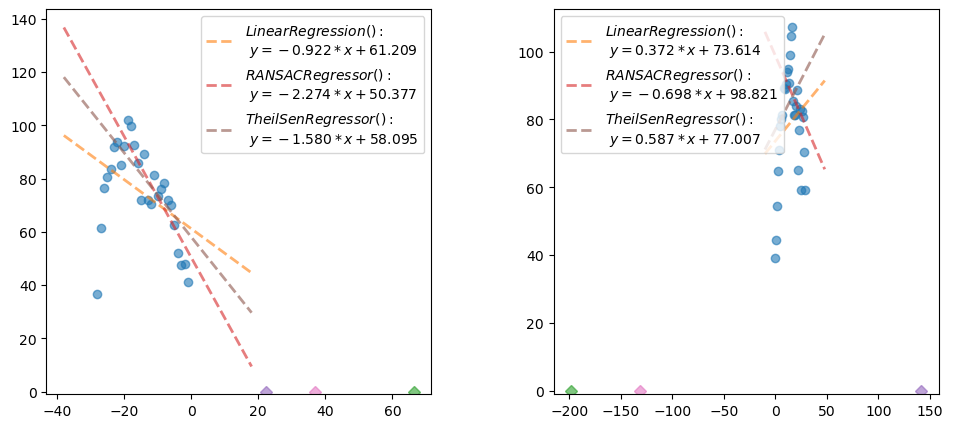

In [42]:
%matplotlib inline
from sklearn import linear_model

means = {"fusion": mean_fusion[-30:], "creation": mean_creation[:30]}
fig, axs = plt.subplots(1,2,  figsize=(12,5))
axs = axs.ravel()

lrs = (
    linear_model.LinearRegression(), 
    linear_model.RANSACRegressor(), 
    linear_model.TheilSenRegressor()
    )

slope_intercept = {}

for ax, (name, mean) in zip(axs, means.items()):
    
    ave_slope, ave_intercept = 0, 0
    y = mean
    X = np.arange(len(mean))

    if name=="fusion":
        X = X - mp_distance_fusion_mat.shape[1]

    ax.plot(X, y, "o", alpha=.6)

    for lr in lrs:
        lr.fit(X.reshape(-1, 1), y)
        try:
            slope = lr.estimator_.coef_[0]
            intercept = lr.estimator_.intercept_
        except:
            slope = lr.coef_[0]
            intercept = lr.intercept_

        # prdict for line
        line_X = np.arange(X.min()-10, X.max()+20)[:, np.newaxis]
        line_y = lr.predict(line_X)

        ax.plot(line_X, line_y, "--", linewidth=2, alpha=.6,
                label="$%s:$\n $y= %.3f *x + %.3f$" %(lr, slope, intercept))   
        ax.plot(-intercept/slope, 0, "D", alpha=.6,)        
        ave_slope += slope  
        ave_intercept += intercept

    # use prints to set the SLOPE and INTERCEP globals in the next cell
    print(name.upper())
    print('slope:', ave_slope/len(lrs), '| intercept:', ave_intercept/len(lrs))
    print('Y=0 @ X=:', -ave_intercept/ave_slope)
    slope_intercept[name] = {"slope": ave_slope/len(lrs), "intercept": ave_intercept/len(lrs)}


    ax.set_box_aspect(1)
    ax.set_ylim([-1,None])

    ax.legend(loc='upper left')
    if name=="fusion":
        ax.legend(loc='upper right')

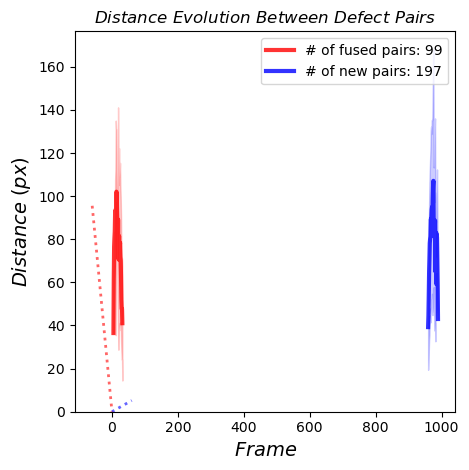

In [43]:
%matplotlib inline
SAVE = False
# FUSION
slope_fusion, intercept_fusion = slope_intercept["fusion"]["slope"], slope_intercept["fusion"]["intercept"] #-2.0 , 23.72
fusion_tshift = - intercept_fusion/slope_fusion -3
# mean_fusion, stdiv = np.flip(np.nanmean(mp_distance_fusion_mat, axis=0)), np.flip(np.nanstd(mp_distance_fusion_mat, axis=0))
time_fusion = np.arange(len(mean_fusion)) - mp_distance_fusion_mat.shape[1] + fusion_tshift

# uncomment to plot in same direction 
# mean, stdiv = np.nanmean(mp_distance_fusion_mat, axis=0), np.nanstd(mp_distance_fusion_mat, axis=0)
# max_frame = 0

plt.plot(time_fusion, mean_fusion, "r-", alpha=.8, linewidth=3,
    label="# of fused pairs: %s" % (mp_distance_fusion_mat.shape[0]))
plt.fill_between(time_fusion, mean_fusion-stdiv_fusion, mean_fusion+stdiv_fusion, color="red", alpha=.2)
xfit = np.array([-60,0])
plt.plot(xfit, slope_fusion * xfit, linestyle="dotted", color="red", alpha=.6, linewidth=2)

# CREATION
slope_creation, intercept_creation =  slope_intercept["creation"]["slope"], slope_intercept["creation"]["intercept"]#2.98, 27.25
creation_tshift = - intercept_creation/slope_creation
# mean_creation, stdiv = np.nanmean(mp_distance_creation_mat, axis=0), np.nanstd(mp_distance_creation_mat, axis=0)
time_creation = np.arange(len(mean_creation)) - creation_tshift

plt.plot(time_creation, mean_creation, "b-", alpha=.8, linewidth=3,
    label="# of new pairs: %s" % (mp_distance_creation_mat.shape[0]))
plt.fill_between(time_creation, mean_creation-stdiv_creation, mean_creation+stdiv_creation, color="b", alpha=.2)
xfit = np.array([0,60])
plt.plot(xfit, slope_creation * xfit, linestyle="dotted", color="b", alpha=.6, linewidth=2,
    )

plt.ylim([0,None])
lim = 60
# plt.xlim([-lim,lim])
plt.gca().set_box_aspect(1)  
plt.xlabel(r'$Frame$', fontsize=14)
plt.ylabel(r'$Distance ~(px)$', fontsize=14) #plt.ylabel('$Distance ~(\mu m)$')
plt.title(r'$Distance ~Evolution ~Between ~Defect ~Pairs$')
plt.tight_layout()
plt.legend()

if SAVE:
    plt.savefig(r"C:\Users\victo\OneDrive - BGU\BEER\B-sub-sur-minus-in-supernatant-40X-100fps\Defects\Images/defect_pair_distance.png")
 

In [44]:
def cofidence_range(X,y):
    import statsmodels.api as sm
    alpha = 0.05 # 95% confidence interval
    lr = sm.OLS(y, sm.add_constant(X)).fit()
    conf_interval = lr.conf_int(alpha)
    print("slope 95% CI ", "[%.2f, %.2f]" % (conf_interval[1][0], conf_interval[1][1]))    


for name, mean in means.items():
    y = mean
    X = np.arange(len(mean))
    print(name.upper())
    cofidence_range(X,y)

# Output of conf_interval
#  lower upper
# [-1.234 0.765]
# [-0.345 0.154]
# This means that we are 95% confident that the true value of the first parameter is between -1.234 and 0.765, 
# and we are 95% confident that the true value of the second parameter is between -0.345 and 0.154.

FUSION
slope 95% CI  [-1.69, -0.15]
CREATION
slope 95% CI  [-0.33, 1.07]


## Flow Averaging Around Defects

In [45]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from natsort import natsorted
from scipy.ndimage import gaussian_filter
from scipy import spatial
from sklearn.neighbors import KDTree
from scipy.stats import circmean, circstd
import os
import sys
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import sys,time,random
import pickle 

def progressBar(count_value, total, suffix=''):
    bar_length = 100
    filled_up_Length = int(round(bar_length* count_value / float(total)))
    percentage = round(100.0 * count_value/float(total),1)
    bar = '=' * filled_up_Length + '-' * (bar_length - filled_up_Length)
    sys.stdout.write('[%s] %s%s ...%s\r' %(bar, percentage, '%', suffix))
    sys.stdout.flush()

experiment = "s19"
plus_minus_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\Defects\PlusAndMinusTM.csv")
plus_minus_df.head()

,Unnamed: 0,LABEL,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,...,CONTRAST_CH1,SNR_CH1,x_img,y_img,x_img1,y_img1,ang1,ang2,ang3,charge
0,0,ID261891,261891,275.0,81.421516,390.0,419.0,0.0,0.0,0,...,0.973672,1.625018,783.228982,1115.424362,783.0,1115.0,0.314159,NaN,NaN,0.5
1,1,ID261890,261890,276.0,81.421516,328.0,414.0,0.0,0.0,0,...,0.973672,1.625018,634.274861,1128.375478,635.0,1128.0,-3.141593,NaN,NaN,0.5
2,2,ID261889,261889,58.0,81.421516,604.0,410.0,0.0,0.0,0,...,0.973672,1.625018,1297.360946,1138.736370,1297.0,1140.0,-0.502655,NaN,NaN,0.5
3,3,ID261888,261888,57.0,81.421516,873.0,409.0,0.0,0.0,0,...,0.973672,1.625018,1943.629630,1141.326593,1944.0,1141.0,-1.005310,NaN,NaN,0.5
4,4,ID261895,261895,277.0,81.421516,192.0,453.0,0.0,0.0,0,...,0.973672,1.625018,307.536791,1027.356773,307.0,1028.0,-2.576106,NaN,NaN,0.5


In [46]:
minushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\Defects\MinusHalf1.csv")
plushalf_df = pd.read_csv(r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\Defects\PlusHalf1.csv")
first_frame = np.max([minushalf_df["frame"].min(), plushalf_df["frame"].min()]) # Validate this number in image folders
last_frame = np.min([minushalf_df["frame"].max(), plushalf_df["frame"].max()])   # Validate this number in image folders


In [58]:
image_list_all = glob.glob(r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\*.tif")
image_list_all = natsorted(image_list_all, key=lambda y: y.lower())
image_list = image_list_all[first_frame-1:last_frame:1]

In [48]:
%matplotlib qt

frame = 12
# pdf = plus_minus_df[(plus_minus_df["FRAME"] == frame) & (plus_minus_df["charge"] == 0.5)]
# mdf = plus_minus_df[(plus_minus_df["FRAME"] == frame) & (plus_minus_df["charge"] == -0.5)]

df = all_pairs_df[all_pairs_df.index == frame]

im1 = image_list[frame]
# Apply Contrast Limited Adaptive Histogram Equalization
img1 = cv2.imread(im1)[:,:,0]
h_img, w_img = img1.shape
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img1)

width, height = 300, 300

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(255-img_clahe, "gray")

# +1/2
# ax.plot(pdf["x_img1"],
#         pdf["y_img1"],'go',
#         markersize=10, alpha=.8, label="TrackMate table")
# ax.quiver(pdf['x_img1'], pdf['y_img1'], 
#     np.cos(pdf['ang1']), -np.sin(pdf['ang1']), 
#     headaxislength=0, headwidth=0, headlength=0, color='g', scale=35, alpha=.8, width=.01)
ax.plot(df["xp"], df["yp"],'mo', markersize=8, alpha=.8)
ax.quiver(df["xp"], df["yp"], 
    np.cos(df['angp1']), -np.sin(df['angp1']), 
    headaxislength=0, headwidth=0, headlength=0, color='m', scale=35, alpha=.8)

# -1/2
# ax.plot(mdf["x_img1"],
#         mdf["y_img1"],'bo',
#         markersize=10, alpha=.8, label="TrackMate table")
# for i in range(3):
#     ax.quiver(mdf["x_img1"], mdf["y_img1"], 
#         np.cos(mdf['ang'+str(i+1)]), -np.sin(mdf['ang'+str(i+1)]), 
#         headaxislength=0, headwidth=0, headlength=0, color='b', scale=30, alpha=.6)
ax.plot(df["xm"], df["ym"],'co', markersize=5, alpha=.8)
for i in range(3):
    ax.quiver(df["xm"], df["ym"], 
        np.cos(df['angm'+str(i+1)]), -np.sin(df['angm'+str(i+1)]), 
        headaxislength=0, headwidth=0, headlength=0, color='c', scale=35, alpha=.6)        


i_all = []
# for i in range(len(pdf["x_img1"])):
#         ulx, uly = pdf["x_img1"].iloc[i] - width//2, pdf["y_img1"].iloc[i] - height//2
#         lrx, lry = pdf["x_img1"].iloc[i] + width//2, pdf["y_img1"].iloc[i] + height//2

for i in range(len(df["xp"])):
        ulx, uly = df["xp"].iloc[i] - width//2, df["yp"].iloc[i] - height//2
        lrx, lry = df["xp"].iloc[i] + width//2, df["yp"].iloc[i] + height//2        
        if (ulx > 0) & (uly>0) & (lrx<w_img) & (lry<h_img):# & (i%2): #(i%1)
                color = "red" if df.fuse_up.iloc[i] else "blue"
                i_all.append(i)
                rect = plt.Rectangle((ulx, uly), 
                                width, height, color=color, fill=False)
                ax.text(lrx, lry, str(i), color='m', fontsize=20)
                ax.add_patch(rect)
print(i_all) 
plt.title("Frame: %s" % frame)               

[3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 47, 48, 50, 51, 52, 54, 55, 57, 58, 59, 60, 61, 63, 66, 67, 69, 70, 71, 72, 73, 74, 75, 77]


Text(0.5, 1.0, 'Frame: 12')

Text(0.5, 1.0, '172')

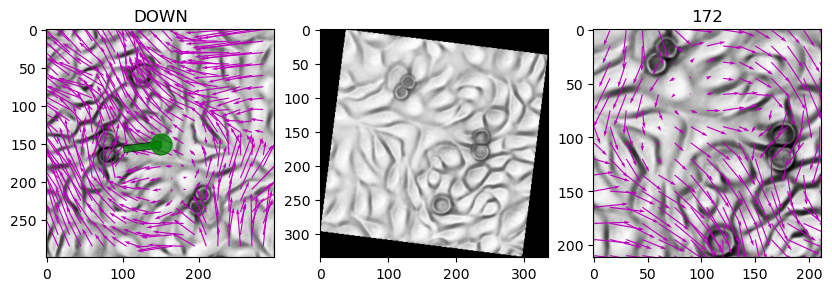

In [49]:
%matplotlib inline
from scipy.ndimage import rotate, gaussian_filter

def crop(img, center, width, height):
    ulx, uly = max(int(center[0] - width//2), 0), max(int(center[1] - height//2), 0)
    lrx, lry = min(int(center[0] + width//2), img.shape[1]), min(int(center[1] + height//2), img.shape[0])
    new_center = ((lrx-ulx)/2 , (lry-uly)/2)
    return img[uly:lry,ulx:lrx], new_center

def rotate_vector(vector, angle):
    '''rotate vectors'''
    x = vector[0] * np.cos(angle) - vector[1] * -np.sin(angle)
    y = vector[0] * -np.sin(angle) + vector[1] * np.cos(angle)
    return [x, y]    

def rotate_flow_field(flow, angle):
    '''rotate flow field'''
    uv_rot = rotate_vector(flow, angle)
    u = rotate(uv_rot[0], angle * 180/np.pi)
    v = rotate(uv_rot[1], angle * 180/np.pi)
    return [u, v]  


i = i_all[11]
# i=4

frame = frame
width, height = 300, 300

img1 = cv2.imread(image_list[frame])[:,:,0] 
img2 = cv2.imread(image_list[frame+1])[:,:,0] 

flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
        winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)  
u, v = flow[:,:,0], flow[:,:,1]
u = gaussian_filter(u, sigma=15)
v = gaussian_filter(v, sigma=15)
y, x = np.mgrid[0:u.shape[0], 0:u.shape[1]]


# pdf = plus_minus_df[(plus_minus_df["FRAME"] == frame) & (plus_minus_df["charge"] == 0.5)]
# mdf = plus_minus_df[(plus_minus_df["FRAME"] == frame) & (plus_minus_df["charge"] == -0.5)]
df = all_pairs_df[(all_pairs_df.index == frame) & (all_pairs_df.fuse_up)]

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img1)

# fig, ax = plt.subplots(1,1, figsize=(10,10))
# ax.imshow(255-img_clahe, "gray")
# step = 15
# ax.quiver(x[::step, ::step], y[::step, ::step], u[::step, ::step], -v[::step, ::step], scale=50, color='m', alpha=.6, width=.005)
# ulx, uly  = pdf["x_img1"].iloc[i] - width//2, pdf["y_img1"].iloc[i] - height//2
# ulx, uly  = df["xp"].iloc[i] - width//2, df["yp"].iloc[i] - height//2
# rect = plt.Rectangle((ulx, uly), 
#                 width, height, color="b", fill=False, linewidth=3)
# ax.add_patch(rect)

# cnt = (int(pdf["x_img1"].iloc[i]), int(pdf["y_img1"].iloc[i]))
cnt = (int(df["xp"].iloc[i]), int(df["yp"].iloc[i]))
image_crop, new_cnt = crop(255-img_clahe, cnt, width, height)

# velocity field
# u = np.ones_like(image_crop)
# v = .5* u
u,_ = crop(flow[:,:,0], cnt, width, height)
v,_ = crop(flow[:,:,1], cnt, width, height)
u = gaussian_filter(u, sigma=15)
v = gaussian_filter(v, sigma=15)
y, x = np.mgrid[0:u.shape[0], 0:u.shape[1]]

fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
ax1.imshow(image_crop, "gray")
step = 15
ax1.quiver(x[::step, ::step], y[::step, ::step], u[::step, ::step], -v[::step, ::step], scale=30, color='m',
     width=.005)

ax1.plot(new_cnt[0], new_cnt[1],'go', markersize=15, alpha=.8, label="TrackMate table")
# ax1.quiver(new_cnt[0], new_cnt[1], np.cos(pdf['ang1'].iloc[i]), -np.sin(pdf['ang1'].iloc[i]), 
#     headaxislength=0, headwidth=0, headlength=0, color='g', scale=6, alpha=.8, 
#     width=.03, linewidth=.5, edgecolor='k')
ax1.quiver(new_cnt[0], new_cnt[1], np.cos(df['angp1'].iloc[i]), -np.sin(df['angp1'].iloc[i]), 
    headaxislength=0, headwidth=0, headlength=0, color='g', scale=6, alpha=.8, 
    width=.03, linewidth=.5, edgecolor='k')

title = "UP" if df.fuse_up.iloc[i] else "DOWN"
ax1.set_title("DOWN")

#rotation angle in degree
# image_rot = rotate(image_crop, pdf["ang1"].iloc[i] * 180/np.pi)
image_rot = rotate(image_crop, df["angp1"].iloc[i] * 180/np.pi)
ax2.imshow(image_rot, "gray")

cnt = image_rot.shape[1]/2, image_rot.shape[0]/2
width1, height1 = (width/2**.5), (height/2**.5)
image_rot_crop, new_cnt = crop(image_rot, cnt, width1, height1)

ax3.imshow(image_rot_crop, "gray")

# uv_rot = rotate_flow_field((u,v), pdf["ang1"].iloc[i])
uv_rot = rotate_flow_field((u,v), df["angp1"].iloc[i])
u = crop(uv_rot[0], cnt, width1, height1)[0]
v = crop(uv_rot[1], cnt, width1, height1)[0]
y, x = np.mgrid[0:u.shape[0], 0:u.shape[1]]

ax3.quiver(x[::step, ::step], y[::step, ::step], u[::step, ::step], -v[::step, ::step], scale=30, color='m',
     width=.005)

plt.title("%2d"%(df["angp1"].iloc[i] * 180/np.pi))

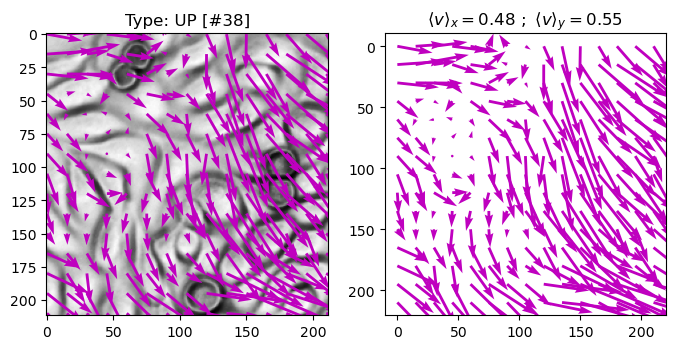

In [50]:
%matplotlib inline

frame = 5
filt = 5 # smoothing average
width, height = 300, 300
width1, height1 = int(width/2**.5), int(height/2**.5)

img1 = cv2.imread(image_list[frame])[:,:,0] 
img2 = cv2.imread(image_list[frame+1])[:,:,0] 
flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
        winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
flow = gaussian_filter(flow, sigma=filt)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img1) 

u_frame = np.zeros((height1, width1), dtype=np.float32)
v_frame = u_frame
count = 0

for i in i_all:
# TODO replace try with padding of boundary defects   
        # print(i)   
        try:
                if df.fuse_up.iloc[i]:  
                        # center at defect position
                        cnt = (int(df["xp"].iloc[i]), int(df["yp"].iloc[i]))
                        #1 crop each component of velocity field
                        
                        # image_crop = crop(255-img_clahe, cnt, width, height)[0] *** image
                        u,_ = crop(flow[:,:,0], cnt, width, height)
                        v,_ = crop(flow[:,:,1], cnt, width, height)

                        #2 rotate velocity field (1. rotate vectors 2. rotate positions) 
                        # image_rot = rotate(image_crop, df["angp1"].iloc[i] * 180/np.pi) *** image
                        uv_rot = rotate_flow_field((u,v), df["angp1"].iloc[i])

                        #3 crop again to smaller box (box**0.5)
                        cnt_crop = uv_rot[0].shape[1]/2, uv_rot[0].shape[0]/2
                        # image_rot_crop = crop(image_rot, cnt_crop, width1, height1)[0] *** image
                        u_frame = u_frame + crop(uv_rot[0], cnt_crop, width1, height1)[0]
                        v_frame = v_frame + crop(uv_rot[1], cnt_crop, width1, height1)[0]
                        count += 1 
                        # break
                        defect_type = "UP" if df.fuse_up.iloc[i] else "DOWN"
        except:
                pass
        #      break

u_frame /= count
v_frame /= count
y, x = np.mgrid[0:height1, 0:width1] 

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.imshow(image_rot_crop, "gray")
ax1.quiver(x[::step, ::step], y[::step, ::step], 
          u_frame[::step, ::step], -v_frame[::step, ::step],  color='m',
          width=.01, scale=6,)
ax1.set_title("Type: %1s [#%1d]" % (defect_type, count))

ax2.quiver(x[::step, ::step], y[::step, ::step], 
          u_frame[::step, ::step], -v_frame[::step, ::step],  color='m',
          width=.01, scale=6,)
ax2.set_title(r"$\langle v \rangle _x =%.2f ~;~ \langle v \rangle _y =%.2f$" % (u_frame.mean(), v_frame.mean()))
ax2.set_box_aspect(1)
ax2.invert_yaxis()

### average sigle frame

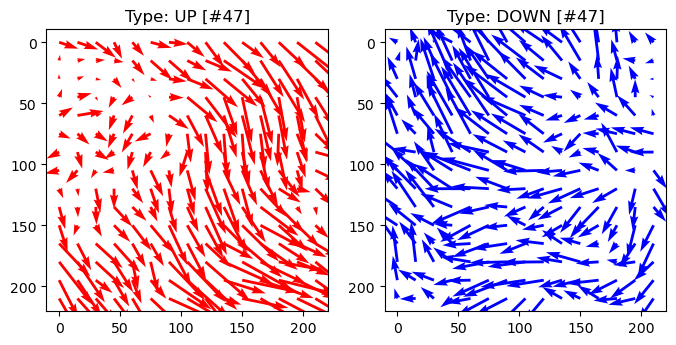

In [51]:
%matplotlib inline

def defect_flow_frame_average(img1,img2, df_frame, defect_type="up", box=(300,300), filt=5):
    width, height = box[0], box[1]
    width1, height1 = int(width/2**.5), int(height/2**.5)
    flow = cv2.calcOpticalFlowFarneback(img1,img2, None, 0.5, 3, 
        winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
    flow = gaussian_filter(flow, sigma=filt)

    if defect_type=="up":
        df = df_frame[df_frame.fuse_up].copy()
    else:
        df = df_frame[~df_frame.fuse_up].copy()

    u_frame = np.zeros((height1, width1), dtype=np.float32)
    v_frame = u_frame
    count = 0

    for i in range(len(df["xp"])):
        try:
            # center at defect position
            cnt = (int(df["xp"].iloc[i]), int(df["yp"].iloc[i]))
            #1 crop each component of velocity field
            
            # image_crop = crop(255-img_clahe, cnt, width, height)[0] *** image
            u,_ = crop(flow[:,:,0], cnt, width, height)
            v,_ = crop(flow[:,:,1], cnt, width, height)

            #2 rotate velocity field (1. rotate vectors 2. rotate positions) 
            # image_rot = rotate(image_crop, df["angp1"].iloc[i] * 180/np.pi) *** image
            uv_rot = rotate_flow_field((u,v), df["angp1"].iloc[i])

            #3 crop again to smaller box (box**0.5)
            cnt_crop = uv_rot[0].shape[1]/2, uv_rot[0].shape[0]/2
            # image_rot_crop = crop(image_rot, cnt_crop, width1, height1)[0] *** image
            u_frame = u_frame + crop(uv_rot[0], cnt_crop, width1, height1)[0]
            v_frame = v_frame + crop(uv_rot[1], cnt_crop, width1, height1)[0]
            count += 1 
        except:
            pass
        #      break

    if count:
        return u_frame/count, v_frame/count, count

frame = 12
img1 = cv2.imread(image_list[frame])[:,:,0] 
img2 = cv2.imread(image_list[frame+1])[:,:,0]  
df_frame = all_pairs_df[all_pairs_df.index == frame]

u_up, v_up, count_up = defect_flow_frame_average(img1,img2, df_frame, defect_type="up")
u_dwn, v_dwn, up_dwn = defect_flow_frame_average(img1,img2, df_frame, defect_type="down")
y, x = np.mgrid[0:u_up.shape[0], 0:u_up.shape[1]] 

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
step = 15
ax1.quiver(x[::step, ::step], y[::step, ::step], 
          u_up[::step, ::step], -v_up[::step, ::step],  color='r',
          width=.01, scale=6,)
ax1.set_title("Type: %1s [#%1d]" % ("UP", count_up))
ax1.set_box_aspect(1) ; ax1.invert_yaxis()

ax2.quiver(x[::step, ::step], y[::step, ::step], 
          u_dwn[::step, ::step], -v_dwn[::step, ::step],  color='b',
          width=.01, scale=6,)
# ax2.set_title(r"$\langle v \rangle _x =%.2f ~;~ \langle v \rangle _y =%.2f$" % (u_frame.mean(), v_frame.mean()))
ax2.set_title("Type: %1s [#%1d]" % ("DOWN", count_up))
ax2.set_box_aspect(1) ; ax2.invert_yaxis()


In [62]:
all_pairs_df

,plus_id,xp,yp,angp1,min_id,xm,ym,angm1,angm2,angm3,...,mp_angle,fusion,angp1_rel,angm1_rel,angm2_rel,angm3_rel,fuse_up,p_vel_angle,p_vel_angle_rel,angp1_rel_vel_angle
FRAME,,,,,,,,,,,,,,,,,,,,,
4,234.0,957.0,193.0,-2.136283,2.0,1024.0,56.0,-2.324779,1.884956,-0.376991,...,5.167239,True,5.262848,5.074353,3.000902,0.738955,True,0.000000,0.000000,4.146902
5,234.0,972.0,174.0,-2.324779,2.0,1022.0,115.0,-2.199115,-0.314159,1.947787,...,5.415405,True,4.826187,4.951851,0.553621,2.815568,True,0.000000,0.000000,3.958407
6,234.0,951.0,189.0,-2.136283,2.0,965.0,166.0,-2.324779,-0.628319,1.884956,...,5.259178,True,5.170910,4.982414,0.395689,2.908963,True,0.000000,0.000000,4.146902
7,234.0,958.0,189.0,-2.513274,2.0,962.0,177.0,-0.753982,-2.450442,1.759292,...,5.034140,True,5.018957,0.495064,5.081789,3.008338,True,-1.325818,-6.359957,5.095729
8,234.0,931.0,194.0,2.387610,2.0,993.0,146.0,-2.324779,-0.376991,1.947787,...,5.624379,True,3.046416,4.617213,0.281815,2.606593,True,2.687749,-2.936631,5.983047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,653.0,940.0,986.0,-2.513274,796.0,903.0,937.0,0.753982,-3.078761,-1.068142,...,4.065631,False,5.987466,2.971537,5.421979,1.149413,True,0.000000,0.000000,3.769911
35,653.0,945.0,982.0,-2.513274,796.0,895.0,927.0,-3.078761,-1.130973,0.879646,...,3.974574,False,6.078523,5.513036,1.177638,3.188257,True,0.000000,0.000000,3.769911
36,653.0,950.0,980.0,-2.576106,796.0,952.0,913.0,-2.261947,2.073451,-0.314159,...,4.742231,False,5.248034,5.562193,3.614406,1.226795,True,-0.352990,-5.095221,4.060070


In [72]:
u_ups, v_ups, count_ups = [], [], []
u_dwns, v_dwns, count_dwns = [], [], []

# all_frames = all_pairs_df.index.unique().values

for frame in all_pairs_df.index.unique().values:
    img1 = cv2.imread(image_list[frame])[:,:,0] 
    img2 = cv2.imread(image_list[frame+1])[:,:,0]  
    df_frame = all_pairs_df[(all_pairs_df.index == frame) & (~all_pairs_df.fusion)]
    u_up, v_up, count_up = defect_flow_frame_average(img1,img2, df_frame, defect_type="up", filt=1)
    u_dwn, v_dwn, count_dwn = defect_flow_frame_average(img1,img2, df_frame, defect_type="down", filt=1)

    u_ups.append(u_up)
    v_ups.append(v_up)
    count_ups.append(count_up)

    u_dwns.append(u_dwn)
    v_dwns.append(v_dwn)
    count_dwns.append(count_dwn)

    if frame % 5:
        save_path = r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\av_flows\av_flows_create.pkl"

        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        with open(save_path, 'wb') as f:
                pickle.dump(dict(u_ups=u_ups, v_ups=v_ups, count_ups=count_ups,
                                u_dwns=u_dwns , v_dwns=v_dwns , count_dwns=count_dwns                     
                                ), f)  

    progressBar(frame, len(all_pairs_df.index.unique().values))


save_path = r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\av_flows\av_flows_create.pkl"

os.makedirs(os.path.dirname(save_path), exist_ok=True)
with open(save_path, 'wb') as f:
        pickle.dump(dict(u_ups=u_ups, v_ups=v_ups, count_ups=count_ups,
                        u_dwns=u_dwns , v_dwns=v_dwns , count_dwns=count_dwns                     
                        ), f)  

IndexError: list index out of range

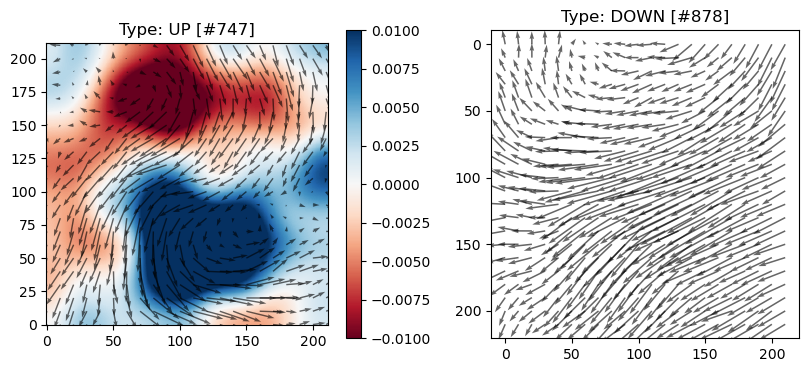

In [75]:
%matplotlib inline

save_path = r"C:\Users\victo\Downloads\SB_lab\HBEC\s2(120-919)\av_flows\av_flows_create.pkl"
with open(save_path, 'rb') as f:
    av_flow = pickle.load(f) 
    
u_ups = np.array(av_flow["u_ups"])
v_ups = np.array(av_flow["v_ups"])
count_ups = np.array(av_flow["count_ups"])

u_dwns = np.array(av_flow["u_dwns"])
v_dwns = np.array(av_flow["v_dwns"])
count_dwns = np.array(av_flow["count_dwns"])

# remove zero counts
u_ups = np.array(u_ups)
v_ups = np.array(v_ups)
count_ups = np.array(count_ups)

u_dwns = np.array(u_dwns)
v_dwns = np.array(v_dwns)
count_dwns = np.array(count_dwns)

tmin, tmax = 1, 37
idx = np.arange(tmin, tmax)
filt = 15

u_up = np.average(u_ups[count_ups!= 0][idx], axis=0, weights=count_ups[count_ups!= 0][idx])
v_up = np.average(v_ups[count_ups!= 0][idx], axis=0, weights=count_ups[count_ups!= 0][idx])

u_dwn = np.average(u_dwns[count_dwns!= 0][idx], axis=0, weights=count_dwns[count_dwns!= 0][idx])
v_dwn = np.average(v_dwns[count_dwns!= 0][idx], axis=0, weights=count_dwns[count_dwns!= 0][idx])

y, x = np.mgrid[0:u_up.shape[0], 0:u_up.shape[1]] 

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
step = 10

field = np.stack((u_up, v_up), axis=-1)
vorticity = gaussian_filter(curl_npgrad(field), sigma=filt)
c = ax1.imshow(vorticity.T, cmap='RdBu', vmin=-.01, vmax=.01)
ax1.quiver(x[::step, ::step], y[::step, ::step], 
          u_up[::step, ::step], v_up[::step, ::step],  color='k',
          width=.005, scale=5, alpha=.6)
ax1.set_title("Type: %1s [#%1d]" % ("UP", np.sum(count_ups[idx])))
ax1.set_box_aspect(1) ; ax1.invert_yaxis()
fig.colorbar(c, ax=ax1)

field = np.stack((u_dwn, v_dwn), axis=-1)
# vorticity = gaussian_filter(curl_npgrad(field), sigma=filt)
# c = ax2.imshow(vorticity.T, cmap='RdBu', vmin=-.01, vmax=.01)

ax2.quiver(x[::step, ::step], y[::step, ::step], 
          u_dwn[::step, ::step], -v_dwn[::step, ::step],  color='k',
          width=.005, scale=5, alpha=.6)       

# ax2.set_title(r"$\langle v \rangle _x =%.2f ~;~ \langle v \rangle _y =%.2f$" % (u_frame.mean(), v_frame.mean()))
ax2.set_title("Type: %1s [#%1d]" % ("DOWN", np.sum(count_dwns[idx])))
ax2.set_box_aspect(1) ; ax2.invert_yaxis()
# fig.colorbar(c, ax=ax2)

In [ ]:
msds = []
for i in range(100):
    t_ = np.arange(0,1e2,1)
    x_ = i + t_ 
    y_ = i +  t_
    id = i

    msds.append(pd.DataFrame({"FRAME": t_, 'X':x_, 'Y':y_, "id": id})) 

df = pd.concat(msds)

df_msd = msd_from_df(df,"X","Y","FRAME","id")

fig, ax1 = plt.subplots(1,1, figsize=(5,5))
# msd_plus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="b", alpha=.05)
# msd_minus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="g", alpha=.05)

win = 1

dfs = [df_msd, df_msd]
colors = ["--r","--b", "-r", "-b"]

for msd_df,color in zip(dfs, colors):
    msd_df = msd_df.sort_values(by="FRAME")
    msd_df["ave"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.mean)
    msd_df["std"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.std)
    msd_df["count"] = roll_func(msd_df.MSD, msd_df.FRAME, win, np.sum)

    ax1.plot(msd_df.FRAME, msd_df["ave"], color, alpha=.6, linewidth=3)
    ax1.fill_between(msd_df.FRAME, 
                    msd_df["ave"]-msd_df["std"]/msd_df["count"]**.5, 
                    msd_df["ave"]+msd_df["std"]/msd_df["count"]**.5, 
                    color=''.join(x for x in color if x.isalpha()), alpha=.2) 


ax1.plot([0,0],[0,0], "-", color="r", linewidth=3, label=r"$+1/2$")
ax1.plot([0,0],[0,0], "-", color="b", linewidth=3, label=r"$-1/2$")
xref = np.arange(4, 10, 1)
ax1.plot(xref, 4e1*xref**.5, "--k", xref, 2e1*xref**1,"--k", xref, 2e1*xref**2,"--k")
ax1.text(xref[0], 4e1*xref[-1]**.5, r"$exp=1/2$", )
ax1.text(xref[0], 2e1*xref[-1]**1, r"$exp=1$")
ax1.set_xscale('log'); ax1.set_yscale('log')
ax1.set_xlabel(r"$Time ~()$", fontsize=14); ax1.set_ylabel(r"$MSD ~(px^2)$", fontsize=14)
plt.legend(loc='upper left', fontsize=12); plt.tight_layout()


In [ ]:
dist = 60
# msd_plus_df_far = msd_from_df(all_pairs_df[all_pairs_df.distance>dist].reset_index(),"xp","yp","FRAME","plus_id")
# msd_minus_df_far = msd_from_df(all_pairs_df[all_pairs_df.distance>dist].reset_index(),"xm","ym","FRAME","min_id")
# msd_plus_df_close = msd_from_df(all_pairs_df[all_pairs_df.distance<dist].reset_index(),"xp","yp","FRAME","plus_id")
# msd_minus_df_close= msd_from_df(all_pairs_df[all_pairs_df.distance<dist].reset_index(),"xm","ym","FRAME","min_id")

msd_plus_df_far = msd_from_df(all_pairs_df.reset_index(),"xp","yp","FRAME","plus_id")
msd_minus_df_far = msd_from_df(all_pairs_df.reset_index(),"xm","ym","FRAME","min_id")


%matplotlib inline
fig, ax1 = plt.subplots(1,1, figsize=(5,5))
# msd_plus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="b", alpha=.05)
# msd_minus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="g", alpha=.05)

win = 3

dfs = [msd_plus_df_far, msd_minus_df_far]#, msd_plus_df_close, msd_minus_df_close]
# dfs = [msd_plus_df_close, msd_minus_df_close]
colors = ["--r","--b", "-r", "-b"]

for msd_df,color in zip(dfs, colors):
    msd_df = msd_df.sort_values(by="FRAME")
    msd_df["ave"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.mean)
    msd_df["std"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.std)
    msd_df["count"] = roll_func(msd_df.MSD, msd_df.FRAME, win, np.sum)

    ax1.plot(msd_df.FRAME, msd_df["ave"], color, alpha=.6, linewidth=3)
    ax1.fill_between(msd_df.FRAME, 
                    msd_df["ave"]-msd_df["std"]/msd_df["count"]**.5, 
                    msd_df["ave"]+msd_df["std"]/msd_df["count"]**.5, 
                    color=''.join(x for x in color if x.isalpha()), alpha=.2) 


ax1.plot([0,0],[0,0], "-", color="r", linewidth=3, label=r"$+1/2$")
ax1.plot([0,0],[0,0], "-", color="b", linewidth=3, label=r"$-1/2$")
xref = np.arange(4, 10, 1)
ax1.plot(xref, 4e2*xref**.5, "--k", xref, 2e2*xref**1,"--k")
ax1.text(xref[0], 4e2*xref[-1]**.5, r"$exp=1/2$", )
ax1.text(xref[0], 2e2*xref[-1]**1, r"$exp=1$")
ax1.set_xscale('log'); ax1.set_yscale('log')
ax1.set_xlabel(r"$Time ~()$", fontsize=14); ax1.set_ylabel(r"$MSD ~(px^2)$", fontsize=14)
plt.legend(loc='upper left', fontsize=12); plt.tight_layout()


In [ ]:
dist = 60
# msd_plus_df_far = msd_from_df(all_pairs_df[all_pairs_df.distance>dist].reset_index(),"xp","yp","FRAME","plus_id")
# msd_minus_df_far = msd_from_df(all_pairs_df[all_pairs_df.distance>dist].reset_index(),"xm","ym","FRAME","min_id")
# msd_plus_df_close = msd_from_df(all_pairs_df[all_pairs_df.distance<dist].reset_index(),"xp","yp","FRAME","plus_id")
# msd_minus_df_close= msd_from_df(all_pairs_df[all_pairs_df.distance<dist].reset_index(),"xm","ym","FRAME","min_id")

# msd_plus_df_far = msd_from_df(all_pairs_df.reset_index(),"xp","yp","FRAME","plus_id")
# msd_minus_df_far = msd_from_df(all_pairs_df.reset_index(),"xm","ym","FRAME","min_id")
msd_plus_df_far = ang_msd_from_df(all_pairs_df.reset_index(),
                              "angp1","FRAME","plus_id", minimal_track=20)

msd_minus_df_far = ang_msd_from_df(all_pairs_df.reset_index(),
                               "angm1","FRAME","min_id",period=2/3*np.pi)



%matplotlib inline
fig, ax1 = plt.subplots(1,1, figsize=(5,5))
# msd_plus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="b", alpha=.05)
# msd_minus_df.plot.scatter("FRAME", "MSD", logx=True, logy=True, ax=ax1, c="g", alpha=.05)

win = 1

dfs = [msd_plus_df_far, msd_minus_df_far]#, msd_plus_df_close, msd_minus_df_close]
# dfs = [msd_plus_df_close, msd_minus_df_close]
colors = ["--r","--b", "-r", "-b"]

for msd_df,color in zip(dfs, colors):
    msd_df = msd_df.sort_values(by="FRAME")
    msd_df["ave"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.mean)
    msd_df["std"] = roll_func(msd_df.MSD, msd_df.FRAME, win, func=np.std)
    msd_df["count"] = roll_func(msd_df.MSD, msd_df.FRAME, win, np.sum)

    ax1.plot(msd_df.FRAME, msd_df["ave"], color, alpha=.6, linewidth=3)
    ax1.fill_between(msd_df.FRAME, 
                    msd_df["ave"]-msd_df["std"]/msd_df["count"]**.5, 
                    msd_df["ave"]+msd_df["std"]/msd_df["count"]**.5, 
                    color=''.join(x for x in color if x.isalpha()), alpha=.2) 


ax1.plot([0,0],[0,0], "-", color="r", linewidth=3, label=r"$+1/2$")
ax1.plot([0,0],[0,0], "-", color="b", linewidth=3, label=r"$-1/2$")
xref = np.arange(4, 10, 1)
ax1.plot(xref, 1e-1*xref**1,"--k")
# ax1.text(xref[0], 4e2*xref[-1]**.5, r"$exp=1/2$", )
# ax1.text(xref[0], 2e2*xref[-1]**1, r"$exp=1$")
ax1.set_xscale('log'); ax1.set_yscale('log')
ax1.set_xlabel(r"$Time ~()$", fontsize=14); ax1.set_ylabel(r"$MSD ~(px^2)$", fontsize=14)
plt.legend(loc='upper left', fontsize=12); plt.tight_layout()


In [ ]:
%matplotlib inline
fig, ax = plt.subplots(1,3, figsize=(10,3))
colors = plt.cm.tab20(np.linspace(0, 1, num=len(pair_stat)))
plt.set_cmap('tab20')
pangles = []
pangles_early = []
pangles_late = []
mangles = []
mpangles = []
p_vel_angles = []
p_vel_angles_rel = []
for num, angs in enumerate(pair_stat):
    # print(angs[0],angs[1])
    # ax[0].plot(np.arange(len(angs[0])), np.fmod(angs[0], 2*np.pi)*180/np.pi, "o", alpha=.1)
    # ax[1].plot(np.arange(len(angs[1])), np.fmod(angs[1], 2*np.pi)*180/np.pi, "o", alpha=.05)
    # pang = np.diff(angs[0])
    # ----------  TODO check how to --------------
    pang = angs[0] % (2*np.pi) #-angs[0][-1]
    # pang[pang<0] = pang[pang<0] + 2*np.pi
    ax[0].plot(-len(pang)+np.arange(len(pang)), (pang+np.pi % (2*np.pi))  * 180/np.pi-180, ".", color="red", alpha=.1)
    ax[1].plot(np.arange(len(angs[1][0])), angs[1][0] % (2/3*np.pi) *180/np.pi, "o", color=colors[num], alpha=.1)

    pangles.append(angs[0][:-1])
    pangles_early.append(angs[0][:-10])
    pangles_late.append(angs[0][-10:])
    mangles.append(np.concatenate(angs[1]))
    p_vel_angles.append(angs[2])
    p_vel_angles_rel.append(angs[3])

    # mpangle = np.min((angs[1] - angs[0]) %(2*np.pi), axis=0)#[-3:]
    mpangles.append(np.concatenate(angs[1] - angs[0]))

    ax[2].plot(np.arange(len(angs[2])), np.array(angs[2]) %(2*np.pi) *180/np.pi, "o", color=colors[num], alpha=.1)
    
    # if num>25:
    #     break

# plt.figure(figsize=(3,3))
# plt.hist(np.concatenate(mpangles) % (2/3*np.pi) *180/np.pi , alpha=.2, rwidth=.9)
# ax[0].set_ylim([-10,370])
# ax[1].set_ylim([-10,130])
# ax[1].set_ylim([0,120])
# ax[0].set_xlim([-1,0])
ax[0].set_title("$Angle ~variation ~of ~+1/2 ~Defects$")
# ax[0].set_ylim([-100,100])

In [ ]:
%matplotlib inline
SAVE = False
bins_number = 45  # the [0, 360) interval will be subdivided into this
# number of equal bins
bins = np.linspace(0, 2*np.pi, bins_number+1)
pangle = np.concatenate(pangles) + 0 * 2*np.pi
mangle = np.concatenate(mangles) + 0 * 2/3*np.pi #2*np.pi * np.ones((1,100)).ravel() #
mpangle = np.concatenate(mpangles) + 0 * 2/3*np.pi
p_vel_angle = np.concatenate(p_vel_angles) + 0 * 2*np.pi

pangle = pangle % (2*np.pi)
mangle = mangle % (2*np.pi)
mpangle = mpangle % (2/3*np.pi)

fig1, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(13,3))
ax1.set_title(r"exp:  " + experiment)
ax2.set_title("$Defect ~angle ~relative ~to$\n $ ~axis ~between ~defect ~pair $")
ax3.set_title("$Relative ~angle$ \n $~between ~+1/2 ~and ~-1/2$")
ax4.set_title(r"+1/2 velocity angle")
pn, _, _ =  ax1.hist(pangle*180/np.pi, bins*180/np.pi, density=True, rwidth=.9, alpha=.5, color="red")
mn, _, _ = ax2.hist(mangle*180/np.pi, bins*180/np.pi, density=True, rwidth=.9, alpha=.5, color="blue")
mpn, _, _ =  ax3.hist(mpangle*180/np.pi, bins*180/np.pi, density=True, rwidth=.9, alpha=.5, color="green")
p_vel, _, _ =  ax4.hist(p_vel_angle*180/np.pi, bins*180/np.pi, density=True, rwidth=.9, alpha=.5, color="green")
plt.tight_layout()
if SAVE:
    fig1.savefig(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_\Images/ang_distribution_hist_" + experiment +".png")


# plt.clf()
width = 2 * np.pi / bins_number
fig2, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, subplot_kw=dict(projection='polar'), figsize=(13,3))
ax1.bar(bins[:bins_number], pn, color="red",width=width, bottom=0.0, alpha=.5)
ax2.bar(bins[:bins_number], mn, color="blue",width=width, bottom=0.0, alpha=.5)
ax3.bar(bins[:bins_number], mpn, color="green",width=width, bottom=0.0, alpha=.5)
ax4.bar(bins[:bins_number], p_vel, color="green",width=width, bottom=0.0, alpha=.5)
ax2.set_title(r"#defect pairs = " + str(len(pair_stat)))
plt.tight_layout()
if SAVE:
    fig2.savefig(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_\Images/ang_distribution_polhist_" + experiment +".png")


In [ ]:
fig3 = plt.figure(figsize=(7,3))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')

p_vel_angle_rel =  np.concatenate(p_vel_angles) % (2*np.pi)

n, _, _ =  ax1.hist(p_vel_angle_rel*180/np.pi, bins*180/np.pi, density=True, rwidth=.6, alpha=.5, color="red")
ax2.bar(bins[:bins_number], n, color="red",width=width, bottom=0.0, alpha=.5)
plt.title("+1/2 defect displacement \n relative to orientation")
plt.tight_layout()
if SAVE:
    fig3.savefig(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_\Images/p_direction_vs_displacement_" + experiment +".png")

In [ ]:
fig3 = plt.figure(figsize=(7,3))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')
bins_number = 60
bins = np.linspace(0, 2*np.pi, bins_number+1)

pangle_early =  np.concatenate(pangles_early) % (2*np.pi)
pangle_late =  np.concatenate(pangles_late) % (2*np.pi)

n1, _, _ =  ax1.hist(pangle_early*180/np.pi, bins*180/np.pi, density=True, rwidth=.8, alpha=.5, color="red")
n2, _, _ =  ax1.hist(pangle_late*180/np.pi, bins*180/np.pi, density=True, rwidth=.8, alpha=.3, color="blue")
ax2.bar(bins[:bins_number], n1, color="red",width=width, bottom=0.0, alpha=.5)
ax2.bar(bins[:bins_number], n2, color="blue",width=width, bottom=0.0, alpha=.3)
# plt.title("+1/2 defect displacement \n relative to orientation")
plt.tight_layout()
plt.title("Eary vs. Late +1/2 Defect Orienatation")

In [ ]:
mp_distance_mat = np.zeros([len(mp_distance), len(max(mp_distance, key = lambda x: len(x)))])
mp_distance_mat[:] = np.nan
for i, dist in enumerate(mp_distance):
    # print(i, j)
    plt.scatter(np.arange(len(dist)), np.flip(dist), c=np.arange(len(dist)), s=5, alpha=.2, cmap="plasma")
    # plt.plot(np.arange(len(dist)), np.flip(dist), alpha=.2)    
    mp_distance_mat[i,0:len(dist)] = np.flip(dist)
    
plt.gca().set_box_aspect(1)  

In [ ]:
%matplotlib inline
for i in range(mp_distance_mat.shape[0]):
    y = mp_distance_mat[i,:][~np.isnan(mp_distance_mat[i,:])]
    # plt.scatter(np.arange(len(y)), y, c=np.arange(len(y)), s=3, alpha=.2, cmap="plasma")


mean, stdiv = np.flip(np.nanmean(mp_distance_mat, axis=0)), np.flip(np.nanstd(mp_distance_mat, axis=0))
max_frame = mp_distance_mat.shape[1]

plt.plot(np.arange(len(mean))-max_frame, mean, "r-", alpha=.8, linewidth=3)
plt.fill_between(np.arange(len(mean))-max_frame, mean-stdiv, mean+stdiv, color="red", alpha=.2)
plt.ylim([0,None])
plt.xlim([None,30])
plt.gca().set_box_aspect(1)  
plt.xlabel('$Frame$')
plt.ylabel(r'$Distance ~(px)$') #plt.ylabel('$Distance ~(\mu m)$')
plt.title(r'$Distance ~Evolution ~Between ~Defect ~Pair$')
plt.tight_layout()
if SAVE:
    plt.savefig(r"C:\Users\victo\Downloads\SB_lab\RPE1_C2C12_\Images/defect_pair_distance_" + experiment +".png")

In [ ]:
plt.plot(xp, yp,"ro", alpha=.1)
plt.plot(xm, ym,"bo", alpha=.1)
plt.gca().set_aspect(1)

## rotation angle in degree

### average multiple frames

In [ ]:
def section(mat, sec_axis="x"):
    ax = 0 if sec_axis=="x" else 1
    section_av = mat.mean(axis=ax)
    section_std = mat.std(axis=ax)
    xx = np.arange(len(section_av))
    return xx, section_av, section_std


c = u_up.shape[0]//2
dc = 50

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
xx, av, std  = section(u_up[:,c-dc:c+dc], sec_axis="y")
ax1.plot(xx, av, "--b")
ax1.fill_between(xx, av-std, av+std,  color="b", alpha=.2)
xx, av, std  = section(v_up[:,c-dc:c+dc], sec_axis="y")
ax2.plot(xx, av, "--b")
ax2.fill_between(xx, av-std, av+std,  color="b", alpha=.2)
ax1.set_title(r"$v_x$"); ax1.set_ylabel(r"$average ~holrisontal ~velocity$"); ax1.set_box_aspect(1)

xx, av, std  = section(u_dwn[:,c-dc:c+dc], sec_axis="y")
ax1.plot(xx, av, "--g")
ax1.fill_between(xx, av-std, av+std,  color="g", alpha=.2)
xx, av, std  = section(v_dwn[:,c-dc:c+dc], sec_axis="y")
ax2.plot(xx, av, "--g")
ax2.fill_between(xx, av-std, av+std,  color="g", alpha=.2)
ax2.set_title(r"$v_y$"); ax2.set_ylabel(r"$average ~vertical ~velocity$"); ax2.set_box_aspect(1)

In [ ]:
a = 0* np.ones_like(u_dwn)
b = 0* np.ones_like(u_dwn)
a[step*6,step*6] = 1
plt.figure()
plt.quiver(x[::step, ::step], y[::step, ::step], 
          a[::step, ::step], -b[::step, ::step],  color='b',
          width=.01, scale=3,)
plt.gca().set_title("Type: %1s [#%1d]" % ("DOWN", np.sum(count_dwns)))
plt.gca().set_box_aspect(1) ; plt.gca().invert_yaxis()